# Exploring Wildland Fires through Data Science: Patterns, Predictive Models, and Insights

Author: Nico David
Date: September 2023

In [1]:
# Loading the basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import re
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Table of Contents <a id="top"></a>

4. [Part 4: Recap](#4) <br>
4.1 [Data](#4.1) <br>
4.2 [Data Dictionary](#4.2) <br>
4.3 [Train/Test Split & Scaling](#4.3) <br>
4.4 [Principal Component Analysis](#4.4) <br>
4.5 [Inital Modeling Results](#4.5) <br>
5. [Part 5: Advanced Modeling](#5) <br>
5.1 [K-Nearest Neighbor](#5.1) <br>
5.2 [Decision Trees](#5.2) <br>
5.3 [Clustering](#5.3) <br>
5.4 [Random Forest](#5.4) <br>
5.5 [Neural Networks](#5.6) <br>
6. [Part 6: Conclusion](#6) <br>
6.1 [Best Model](#6.2) <br>
6.2 [Next Steps](#6.3) 





# Recap <a id="4"></a>

This will be the second continuation of our exploration into wildland fires. Wildland fires continue to affect many aspects of human life. Recent media updates during the 2023 summer season paints a very troubling picture. Given that Canada spends around 800 million to 1.4 billion annualy for wildland fire management creates a problem space that we can look into. It not only affects human lives but has a tremendously steep impact to our ecological system. Although wildland fires can sometimes be beneficial, an increase in severity and occurances could damage our natural landscape as well. It sometimes takes hunderds of years before some species of trees eventually return to an area.


We started our exploration by looking at both our fire and weather datasets. Both datasets needed extensive cleaning as both datasets had duplicates and a lot of null values. We moved on to univariate feature analysis finding some interesting insights as well as features that do not contain valuable information. We then combined our datasets to incorporate weather data. Since fire occurances can happen almost anywhere and weather stations are in specific locations, we created a formula to calculate the weather station with the closest distance that has information for that month/year. We moved on to analyzing our independent variables to our target variable and looked at the correlation between each of the features. We transformed our categorical data into binary features as well as readied our target feature for modeling. We ended with a base model that we can use to further evaluate future models. As always, this would be a iterative processs where our future models might give us insight on how to better clean our data or create new features. 

## Data <a id="4.1"></a>

We will load the cleaned data that we have exported from the previous notebook.

In [2]:
# Importing csv
df = pd.read_csv('data/final_capstone_modeling_data.csv', index_col='FID')

# Santiy check
df.head()

,LATITUDE,LONGITUDE,MONTH,DAY,DwTm,Tx,S,P,DwP,fcount_1yr_1diff,...,ECOZ_NAME_Montane Cordillera,ECOZ_NAME_Northern Arctic,ECOZ_NAME_Pacific Maritime,ECOZ_NAME_Prairie,ECOZ_NAME_Southern Arctic,ECOZ_NAME_Taiga Cordillera,ECOZ_NAME_Taiga Plain,ECOZ_NAME_Taiga Shield East,ECOZ_NAME_Taiga Shield West,severity
FID,,,,,,,,,,,,,,,,,,,,,
0,59.963,-128.172,5,26,0.0,26.7,2.5,33.0,0.0,0,...,0,0,0,0,0,0,0,0,0,3
1,59.318,-132.172,6,22,0.0,31.7,0.0,32.5,0.0,5,...,0,0,0,0,0,0,0,0,0,3
2,59.876,-131.922,6,4,0.0,31.7,0.0,32.5,0.0,1,...,0,0,0,0,0,0,0,0,0,6
3,59.760,-132.808,7,15,0.0,31.1,0.0,34.6,0.0,4,...,0,0,0,0,0,0,0,0,0,5
4,59.434,-126.172,6,12,0.0,23.9,0.0,93.5,0.0,2,...,0,0,0,0,0,0,0,0,0,3


Although we have already created buckets of severity from our previous notebook, we still have to change the labeling since a few of our models especially neural networks accept sequential integer labels that start with a 0 value.

In [3]:
# Define a mapping between original values and adjusted values
value_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}  # Example mapping, adjust based on your requirements

# Replace values in the DataFrame using the mapping
df['severity'] = df['severity'].replace(value_mapping)


## Data Dictionary <a id="4.2"></a>

Since we have created a few new features as well as deleted others, we created a new data dictionary to reference to.

| Column | Values | Description |
|--------|--------|-------------|
| LATITUDE | Numerical | Geospatial coordinates of fire occurance|
| LONGITUDE | Numerical | Geospatial coordiantes of fire occurance|
| Month | Datetime | Month of fire occurance |
| Day | Datetime | Day of fire occurance |
| DwTm| Numerical | Days without valid Mean Temperature |
| Tx | Numerical | Highest Monthly Maximum Temperature (°C) |
| S | Numerical | Snowfall (cm) |
| P | Numerical | Total Precipitation (mm) |
| DwP | Numerical | Days without Valid Precipitation |
| fcount_1yr_1diff | Numerical | Number of fire occurances 1 year or less & within 1 lat/long difference |  
| fcount_1to5yr_1diff | Numerical | Number of fire occurances between 1 and 5 years & within 1 lat/long difference |  
| fcount_5to15yr_1diff | Numerical | Number of fire occurances between 5 and 15 years & within 1 lat/long difference |  
| fcount_15to45yr_1diff | Numerical | Number of fire occurances between 15 and 45 years & within 1 lat/long difference |  
| fcount_1to5yr_1to3diff | Numerical | Number of fire occurances between 1 and 5 years & between 1 and 3 lat/long difference |  
| fcount_5to15yr_1to3diff | Numerical | Number of fire occurances between 5 and 15 years & between 1 and 3 lat/long difference |  
| fcount_15to45yr_1to3diff | Numerical | Number of fire occurances between 15 and 45 years & between 1 and 3 lat/long difference |  
| fcount_1yr_1to3diff | Numerical | Number of fire occurances 1 year or less & between 1 and 3 lat/long difference |  
| SRC_AGENCY_AB | Binary | 1 if reporting agency was Alberta |                 
| SRC_AGENCY_BC | Binary | 1 if reporting agency was British Columbia |    
| SRC_AGENCY_MB | Binary | 1 if reporting agency was Manitoba |    
| SRC_AGENCY_NB | Binary | 1 if reporting agency was New Brunswick |  
| SRC_AGENCY_NS | Binary | 1 if reporting agency was Nova Scotia |  
| SRC_AGENCY_NT | Binary | 1 if reporting agency was Northwest Territories |  
| SRC_AGENCY_ON | Binary | 1 if reporting agency was Ontario |  
| SRC_AGENCY_PC | Binary | 1 if reporting agency was Parks Canada |  
| SRC_AGENCY_QC | Binary | 1 if reporting agency was Quebec |  
| SRC_AGENCY_SK | Binary | 1 if reporting agency was Saskatchewan |  
| SRC_AGENCY_YT | Binary | 1 if reporting agency was Yukon Teritories |
| CAUSE_H | Binary | 1 if cause of fire occurance is by human activity |         | CAUSE_H-PB | Binary | 1 if cause of fire occurance is by human prescribed burns |
| CAUSE_L | Binary | 1 if cause of fire occurance is by lightning activity |    
| CAUSE_RE | Binary | 1 if cause of fire occurance is a reignition of a previous occurance | 
| ECOZ_NAME_Atlantic Maritime | Binary | 1 if location of fire occurance is in Atlantic Martime | 
| ECOZ_NAME_Boreal Cordillera | Binary | 1 if location of fire occurance is in Boreal Cordillera |  
| ECOZ_NAME_Boreal PLain | Binary | 1 if location of fire occurance is in Boreal Plain |  
| ECOZ_NAME_Boreal Shield East | Binary | 1 if location of fire occurance is in Boreal Sheild East | 
| ECOZ_NAME_Boreal Shield West | Binary | 1 if location of fire occurance is in Boreal Shield West | 
| ECOZ_NAME_Hudson Plain | Binary | 1 if location of fire occurance is in Hudson Plain |
| ECOZ_NAME_MixedWood Plain | Binary | 1 if location of fire occurance is in MixedWood Plain |  
| ECOZ_NAME_Montane Cordillera  | Binary | 1 if location of fire occurance is in Montane Cordillera |  
| ECOZ_NAME_Northern Arctic | Binary | 1 if location of fire occurance is in Northern Arctic |  
| ECOZ_NAME_Pacific Maritime | Binary | 1 if location of fire occurance is in Pacific Maritime |  
| ECOZ_NAME_Prairie | Binary | 1 if location of fire occurance is in Prairie |  
| ECOZ_NAME_Southern Arctic | Binary | 1 if location of fire occurance is in Southern Arctic |  
| ECOZ_NAME_Taiga Cordillera | Binary | 1 if location of fire occurance is in Taiga Cordillera |  
| ECOZ_NAME_Taiga Plain | Binary | 1 if location of fire occurance is in Taiga Plain |  
| ECOZ_NAME_Taiga Shield East | Binary | 1 if location of fire occurance is in Taiga Sheild |
| ECOZ_NAME_Taiga Shield West | Binary | 1 if location of fire occurance is in Taiga Sheild West |  
| severity | Categorical | Severity based on number of hectares burned |

## Train/Test Split & Scaling <a id="4.3"></a>

### Train/Test Split

We will split and scale our data the exact same way in our first notebook to continue our process.

In [4]:
# Train/Test Split

# Defining X(independent) and y(target) variables
X = df.drop(columns=['severity'])
y = df['severity']

# Splitting to extract test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

# Splitting again to get train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=1)

# Sanity check
print(f"The shape of our X_test is {X_test.shape}")
print(f"The shape of our y_test is {y_test.shape}")
print(f"The shape of our X_train is {X_train.shape}")
print(f"The shape of our y_train is {y_train.shape}")
print(f"The shape of our X_validation is {X_validation.shape}")
print(f"The shape of our y_validation is {X_validation.shape}")

The shape of our X_test is (77015, 48)
The shape of our y_test is (77015,)
The shape of our X_train is (215642, 48)
The shape of our y_train is (215642,)
The shape of our X_validation is (92418, 48)
The shape of our y_validation is (92418, 48)


We have the same counts for our train test split from our previous notebook.

### Scaling

We will scale our data since our features are a mix of numerical and binary values. In addition, some of the numerical features have different scales of measurments as well. To avoid bias to the higher numerical values with lower scales of measurements, we will scale all our independent features.

In [5]:
# Instantiate standard scaler
scaler = StandardScaler()

# Fitting only on train
scaler.fit(X_train)

# Transform train and test
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

## Principal Component Analysis <a id="4.4"></a>

We will use PCA on our data since it offers the following benefits:
1. It reduces the noise or irrelevant features. 
2. It allows us to focus on the more important features in our data.
3. It helps us lower any remaining collinearity.

### Testing for Number of Components

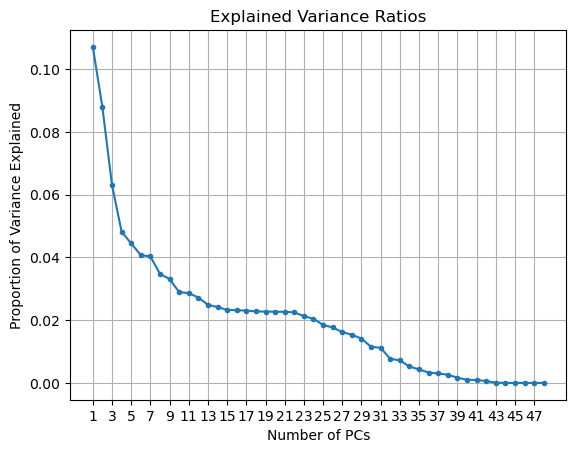

In [6]:
# Instantiate and fit PCA
test_PCA = PCA()
test_PCA.fit(X_train_scaled)

# Extracting results of variance ratios
expl_var = test_PCA.explained_variance_ratio_

# Plotting explained variance ratios
plt.figure()
plt.plot(range(1,49),expl_var,marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.title('Explained Variance Ratios')
plt.xticks(range(1,49,2))
plt.grid()
plt.show()

Insights from Explained Variance Ratio graph:
1. There seems to be 2 distinct elbows in our graph. The first one is around 10 and the second is around 31. 
2. It does not give a clear indication of how many pca components to pick. 

<br>

We will look at the cummulative sum to see if it can better guide us in choosing the number of PCA components

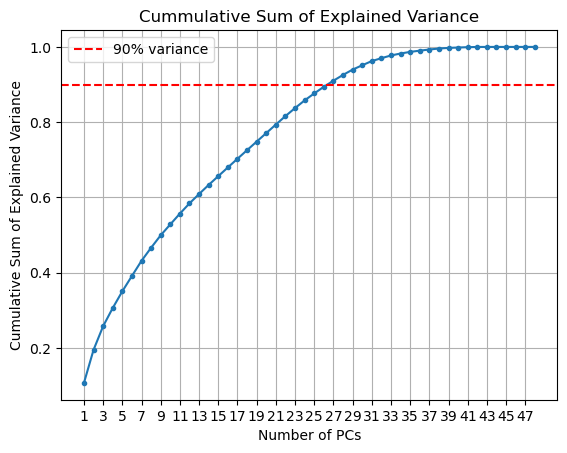

In [7]:
# Calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(expl_var)

# Plot out the cumulative sum graph
plt.figure()
plt.plot(range(1,49), cumulative_sum, marker='.')
plt.axhline(0.90, c='r', linestyle='--', label='90% variance')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.title('Cummulative Sum of Explained Variance')
plt.xticks(range(1,49,2))
plt.legend()
plt.grid()
plt.show()

Insights from Explained Variance Ratio graph:
1. By trying to retain 90% of our variance (red line), we can see that we need roughly 26 components.
2. The cummulative sum of explained variance flattens out at around 29 components.


### Final PCA 

We will fit and transform all our scaled sets using a PCA with 26 components as explained above.

In [8]:
# Instantiate and fit on scaled data for KNN, SVM, etc
my_PCA = PCA(n_components = 26)
my_PCA.fit(X_train_scaled)
# Transform train, validation, and test
X_train_scaled = my_PCA.transform(X_train_scaled)
X_validation_scaled = my_PCA.transform(X_validation_scaled)
X_test_scaled = my_PCA.transform(X_test_scaled)

## Smote

In [9]:
smote = SMOTE()
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

## Inital Modeling Results <a id="4.5"></a>

We will run our inital modeling results from the previous notebook for easier comparisson of our model results. We will also recreate our modeling results dataframe.

In [118]:
# Creating empty dataframe for scores
compiled_scores_df = pd.DataFrame(columns=['Model', 'Hyperparamater', 'Train_Recall', 'Validation_Recall', 'Notes'])

### Logistic Model

In [11]:
# Instantiate, fit, and score the model
log_model = LogisticRegression(max_iter=10000)
log_model.fit(X_train_scaled, y_train)
log_y_train_pred = log_model.predict(X_train_scaled)
log_y_val_pred = log_model.predict(X_validation_scaled)

# Looking at scores
log_train_recall = recall_score(y_train, log_y_train_pred, average='macro')
log_val_recall = recall_score(y_validation, log_y_val_pred, average='macro')

# Printing scores
print(f"Our logistic model has a train recall score of {log_train_recall}")
print(f"Our logistic model has a validation recall score of {log_val_recall}")

Our logistic model has a train recall score of 0.37977183875948617
Our logistic model has a validation recall score of 0.3781392605671507


Insights from Logistic Model:
1. Very low recall scores. Does not predict severity very well.
2. We do not see signs of over/under fitting.

In [119]:
# Appending into scores dataframe
inital_log_model = {'Model': 'Logistic', 'Hyperparamater': 'None', 
                    'Train_Recall': log_train_recall, 
                    'Validation_Recall': log_val_recall, 
                    'Notes': 'Inital model. No overfitting'}
compiled_scores_df = compiled_scores_df.append(inital_log_model, ignore_index=True)

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\857995861.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compiled_scores_df = compiled_scores_df.append(inital_log_model, ignore_index=True)


# Advanced Modeling <a id="5"></a>

## KNeighbors Classfier <a id="5.1"></a>

Since we are dealing with a classification problem, we will use KNN since it helps us look at classfication problems with a few more hyperparameters to play around with.

### Initial KNN model

In [13]:
#Instantiate, fit, and predict
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
knn_y_train_pred = knn_model.predict(X_train_scaled)
knn_y_val_pred = knn_model.predict(X_validation_scaled)

# Score the model on the test set
knn_train_recall = recall_score(y_train, knn_y_train_pred, average='macro')
knn_val_recall = recall_score(y_validation, knn_y_val_pred, average='macro')

# Print scores
print(f"Our knn model has a train recall score of {knn_train_recall}")
print(f"Our knn model has a validation recall score of {knn_val_recall}")

Our knn model has a train recall score of 0.8839441177436842
Our knn model has a validation recall score of 0.3933252416668962


Insights from Initial KNN Model:
1. We have improved our train scores compared to our logistic model.
2. We see overfitting in our inital KNN model since there is a ~ 49% difference between train and validation scores.
3. Given that the default n_neighbors value is 5, we will try to enter larger n_neighbors to see if we can tune the model. 

In [120]:
# Adding scores to compiled scores df
inital_knn_model = {'Model': 'KNN', 'Hyperparamater': 'None', 
                    'Train_Recall': knn_train_recall, 
                    'Validation_Recall': knn_val_recall, 
                    'Notes': 'Initial model. Massive overfitting.'}
compiled_scores_df = compiled_scores_df.append(inital_knn_model, ignore_index=True)
compiled_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\1082842677.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compiled_scores_df = compiled_scores_df.append(inital_knn_model, ignore_index=True)


,Model,Hyperparamater,Train_Recall,Validation_Recall,Notes
0,Logistic,None,0.379772,0.378139,Inital model. No overfitting
1,KNN,None,0.883944,0.393325,Initial model. Massive overfitting.


### N_Neighbors Hyperparameter

We will look at different values of n_neighbor to see if we can get our model to perform better. 

In [15]:
# Creating empty lists
knn_train_recall_list = []
knn_val_recall_list = []

# Running a for loop to look at different n_neighbor values
for n in range(61, 422, 60):     
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model.fit(X_train_scaled, y_train)
    knn_y_train_pred = knn_model.predict(X_train_scaled)
    knn_y_val_pred = knn_model.predict(X_validation_scaled)

    # Score the model on the test set
    knn_train_recall = recall_score(y_train, knn_y_train_pred, average='macro')
    knn_val_recall = recall_score(y_validation, knn_y_val_pred, average='macro')
    
    # Appending scores on a list
    knn_train_recall_list.append(knn_train_recall)
    knn_val_recall_list.append(knn_val_recall)

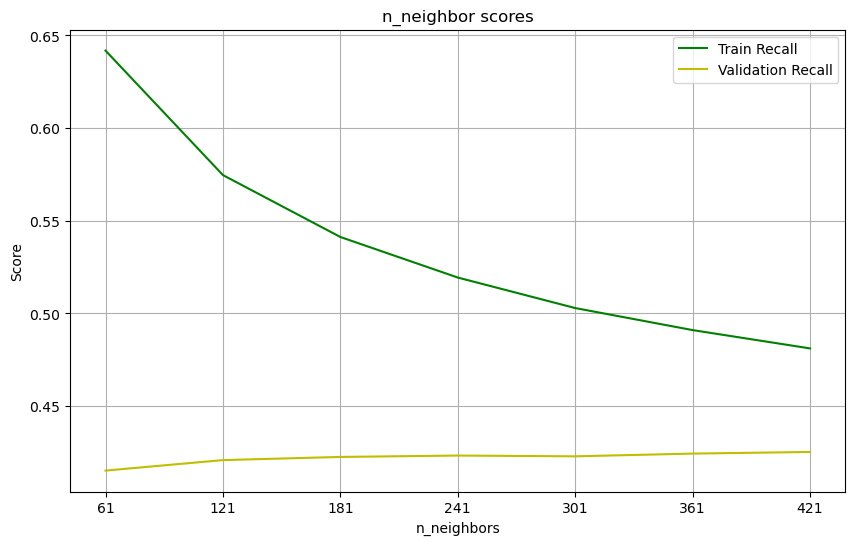

In [16]:
# Plot n_neighbors scores
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(knn_train_recall_list))), y=knn_train_recall_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(knn_val_recall_list))), y=knn_val_recall_list, color='y', label='Validation Recall')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title('n_neighbor scores')
plt.grid()
plt.legend()
plt.xticks(ticks=np.arange(0,7,1), labels=np.arange(61, 422, 60))
plt.show()

Insights from n_neighbors graph:
1. We have massive overfitting even with a 61 n_neighbors. It is still a ~ 20% difference between train and validation.
2. The train recall line is slowly decreasing and reducing the overfitting as n_neighbors increase.
2. A n_neighbors of 421 seems visually acceptable since we have less overfitting.

### Leaf Sizes Hyperparameter

We will look at different leaf sizes to see if our model performs better.

In [17]:
# Creating empty list
knn_train_recall_list = []
knn_val_recall_list = []

# Starting for loop to go through different leaf sizes
for n in range(30, 271, 40):     
    knn_model = KNeighborsClassifier(leaf_size=n)
    knn_model.fit(X_train_scaled, y_train)
    knn_y_train_pred = knn_model.predict(X_train_scaled)
    knn_y_val_pred = knn_model.predict(X_validation_scaled)

    # Score the model on the test set
    knn_train_recall = recall_score(y_train, knn_y_train_pred, average='macro')
    knn_val_recall = recall_score(y_validation, knn_y_val_pred, average='macro')
    
    # Appending scores into list
    knn_train_recall_list.append(knn_train_recall)
    knn_val_recall_list.append(knn_val_recall)

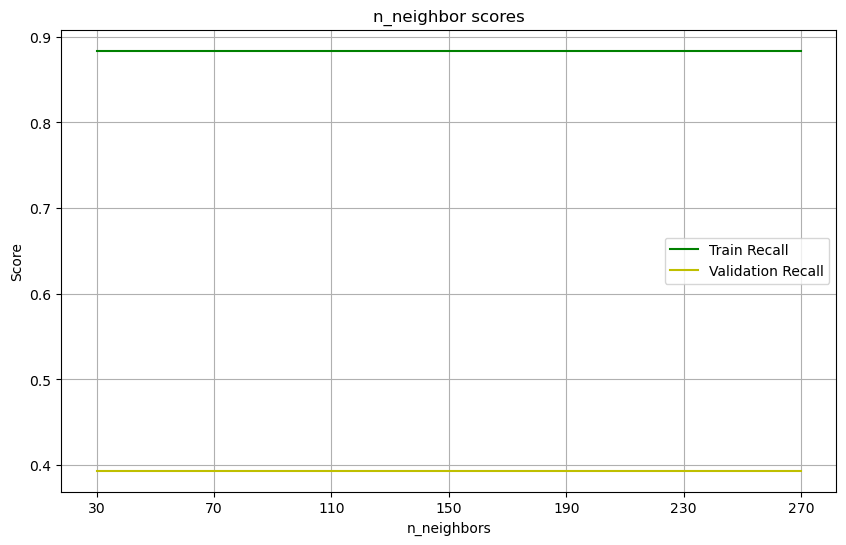

In [18]:
# Plot n_leaf_sample
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(knn_train_recall_list))), y=knn_train_recall_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(knn_val_recall_list))), y=knn_val_recall_list, color='y', label='Validation Recall')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title('n_neighbor scores')
plt.grid()
plt.legend()
plt.xticks(ticks=np.arange(0,7,1), labels=np.arange(30, 271, 40))
plt.show()

Insights from leaf_size graph:
1. Leaf sizes do not play as important a hyperparameter since the train and validation scores did not change.
2. We will not include leaf size as a hyperparamter.

### Final KNN Model

In [19]:
#Instantiate, fit, and predict
final_knn_model = KNeighborsClassifier(n_neighbors=421)
final_knn_model.fit(X_train_scaled, y_train)
final_knn_y_train_pred = final_knn_model.predict(X_train_scaled)
final_knn_y_val_pred = final_knn_model.predict(X_validation_scaled)

# Score the model on the test set
final_knn_train_recall = recall_score(y_train, final_knn_y_train_pred, average='macro')
final_knn_val_recall = recall_score(y_validation, final_knn_y_val_pred, average='macro')

# Print scores
print(f"Our final knn model has a train recall score of {final_knn_train_recall}")
print(f"Our final knn model has a validation recall score of {final_knn_val_recall}")

Our final knn model has a train recall score of 0.48106048161897563
Our final knn model has a validation recall score of 0.4251865370561793


### Insights from KNN model

1. Having a smaller dataset allowed us to use KNN without using too much computational power.
2. Our fire data has some outliers that KNN is able to account since it measures the distance between points.
3. Although sensitive to weights/measures of the data, we used scaled data to hopefully prevent any feature from dominating the model.
4. Since KNN measures all the distances between features ,we used PCA to help the KNN model adapt to irrelevant features and help it understand the data better. We did this in order for the KNN model to give more importance to certain features.

In [121]:
# Adding scores to compiled scores df
final_knn_model = {'Model': 'KNN', 'Hyperparamater': 'n_neighbors=421', 
                   'Train_Recall': final_knn_train_recall, 
                   'Validation_Recall': final_knn_val_recall, 
                   'Notes': 'Final KNN. Still has slight overfitting'}

compiled_scores_df = compiled_scores_df.append(final_knn_model, ignore_index=True)
compiled_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\2361315939.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compiled_scores_df = compiled_scores_df.append(final_knn_model, ignore_index=True)


,Model,Hyperparamater,Train_Recall,Validation_Recall,Notes
0,Logistic,None,0.379772,0.378139,Inital model. No overfitting
1,KNN,None,0.883944,0.393325,Initial model. Massive overfitting.
2,KNN,n_neighbors=421,0.481060,0.425187,Final KNN. Still has slight overfitting


## Decision Tree <a id="5.2"></a>

Since we are dealing with a classification problem, we will use Decision Trees since it helps us look at classfication problems with a few more hyperparameters to play around with.

### Initial Decision Tree Model

In [21]:
#Fit to the training data
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)
dt_y_train_pred = dt_model.predict(X_train_scaled)
dt_y_val_pred = dt_model.predict(X_validation_scaled)

# Score the model on the test set
dt_train_recall = recall_score(y_train, dt_y_train_pred, average='macro')
dt_val_recall = recall_score(y_validation, dt_y_val_pred, average='macro')

# Print scores
print(f"Our initial Decision Tree has a train recall score of {dt_train_recall}")
print(f"Our initial Decision Tree has a validation recall score of {dt_val_recall}")

Our initial Decision Tree has a train recall score of 0.9996071377728134
Our initial Decision Tree has a validation recall score of 0.3537027255949698


Insights from initial Decision Tree model
1. Accuracy and recall scores are similar to each other for train and validation.
2. We see heavy overfitting for the base model as there is a 64% difference in scores.
3. Since we have major overfitting in our base model, it could be very beneficial to use random forest as an ensemble method in the future.

In [122]:
# Adding scores to compiled scores df
inital_dt_model = {'Model': 'Decision Trees', 
                   'Hyperparamater': 'None', 
                   'Train_Recall': dt_train_recall, 
                   'Validation_Recall': dt_val_recall, 
                   'Notes': 'Inital model. Massive overfitting.'}

compiled_scores_df = compiled_scores_df.append(inital_dt_model, ignore_index=True)
compiled_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\3908810901.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compiled_scores_df = compiled_scores_df.append(inital_dt_model, ignore_index=True)


,Model,Hyperparamater,Train_Recall,Validation_Recall,Notes
0,Logistic,None,0.379772,0.378139,Inital model. No overfitting
1,KNN,None,0.883944,0.393325,Initial model. Massive overfitting.
2,KNN,n_neighbors=421,0.481060,0.425187,Final KNN. Still has slight overfitting
3,Decision Trees,None,0.672272,0.384898,Inital model. Massive overfitting.


   ### Max Depth Hyperparameter

We will now look at the max_depth hyperparamter

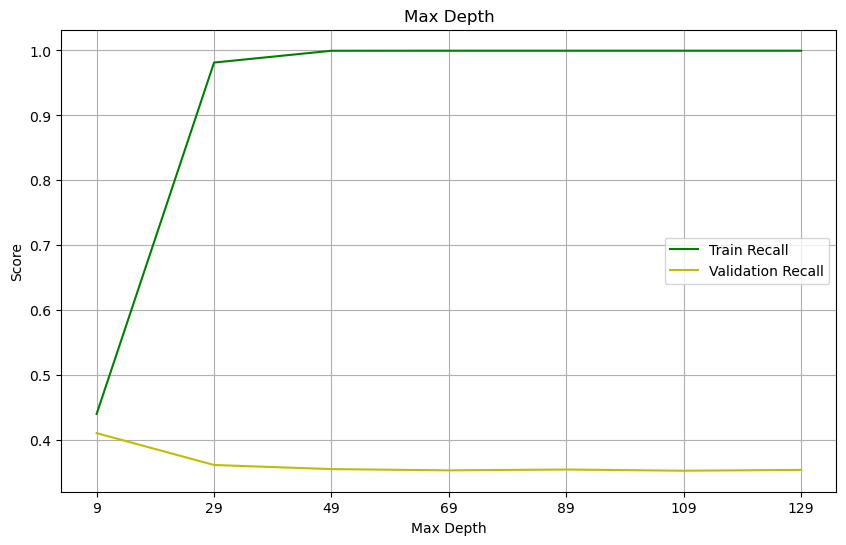

In [24]:
# Creating empty lists
dt_train_recall_max_depth_list = []
dt_val_recall_max_depth_list = []

# Starting for loop to go through different max_depths
for n in range(9, 130, 20):     
    dt_model = DecisionTreeClassifier(max_depth=n)
    dt_model.fit(X_train_scaled, y_train)
    dt_y_train_pred = dt_model.predict(X_train_scaled)
    dt_y_val_pred = dt_model.predict(X_validation_scaled)

    # Score the model on the test set
    dt_train_recall = recall_score(y_train, dt_y_train_pred, average='macro')
    dt_val_recall = recall_score(y_validation, dt_y_val_pred, average='macro')
    
    # Appending scores
    dt_train_recall_max_depth_list.append(dt_train_recall)
    dt_val_recall_max_depth_list.append(dt_val_recall)

# Plot max_depth
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(dt_train_recall_max_depth_list))), y=dt_train_recall_max_depth_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(dt_val_recall_max_depth_list))), y=dt_val_recall_max_depth_list, color='y', label='Validation Recall')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Max Depth')
plt.grid()
plt.legend()
plt.xticks(ticks=np.arange(0,7,1), labels=np.arange(9, 130, 20))
plt.show()

Insights from max_depth graph:
1. We can see overfitting as soon as we have a max_depth of 29. The validation scores decrease while the train scores increase rapidly close to 99%
2. We will use a max_depth of of 9 for our decision tree model. Visually, a 9 in max_depth seems to help us prevent overfitting while getting the best train/validation scores as possible.

### Min Leaf Hyperparameter

We will now look at the min_leaf hyperparamer.

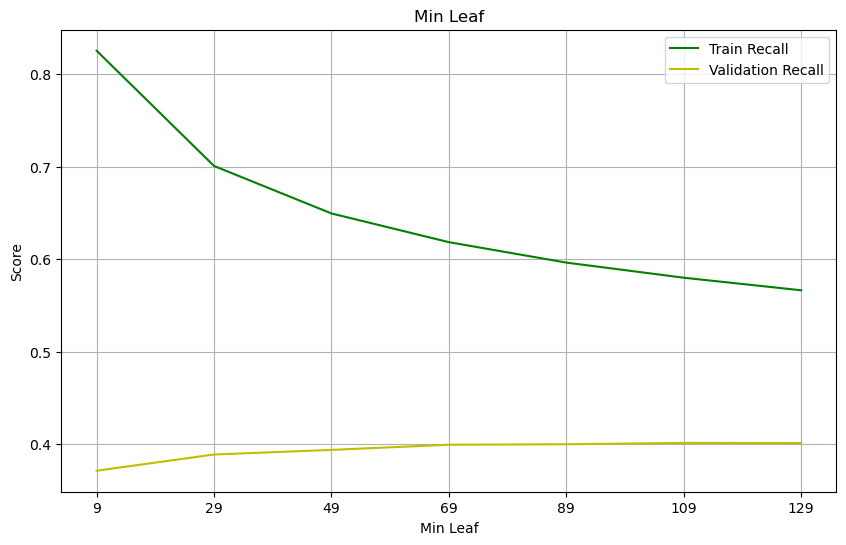

In [25]:
# Creating empty lists for scores
dt_train_acc_min_leaf_list = []
dt_val_acc_min_leaf_list = []
dt_train_recall_min_leaf_list = []
dt_val_recall_min_leaf_list = []

# Looping through different min_samples_leaf
for n in range(9, 130, 20):     
    dt_model = DecisionTreeClassifier(min_samples_leaf=n)
    dt_model.fit(X_train_scaled, y_train)
    dt_y_train_pred = dt_model.predict(X_train_scaled)
    dt_y_val_pred = dt_model.predict(X_validation_scaled)

    # Score the model on the test set
    dt_train_recall = recall_score(y_train, dt_y_train_pred, average='macro')
    dt_val_recall = recall_score(y_validation, dt_y_val_pred, average='macro')
    
    # Append scores on list
    dt_train_recall_min_leaf_list.append(dt_train_recall)
    dt_val_recall_min_leaf_list.append(dt_val_recall)
    
# Plot min_leaf
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(dt_train_recall_min_leaf_list))), y=dt_train_recall_min_leaf_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(dt_val_recall_min_leaf_list))), y=dt_val_recall_min_leaf_list, color='y', label='Validation Recall')
plt.xlabel('Min Leaf')
plt.ylabel('Score')
plt.title('Min Leaf')
plt.grid()
plt.legend()
plt.xticks(ticks=np.arange(0,7,1), labels=np.arange(9, 130, 20))
plt.show()

Insights from min_leaf graph:
1. The recall and accurance scores are exactly the same for both train and validation.
2. The train scores drops significantly from the low 80s and flattens around the high 60s. The validation scores on the other hand jump up from the high 50s before flattening out in the low 60s.
3. A min_leaf of 36 allows us to have a closer train and validation scores.

### Min Split Hyperparameter

We will now look at the min_split hyperparamer.

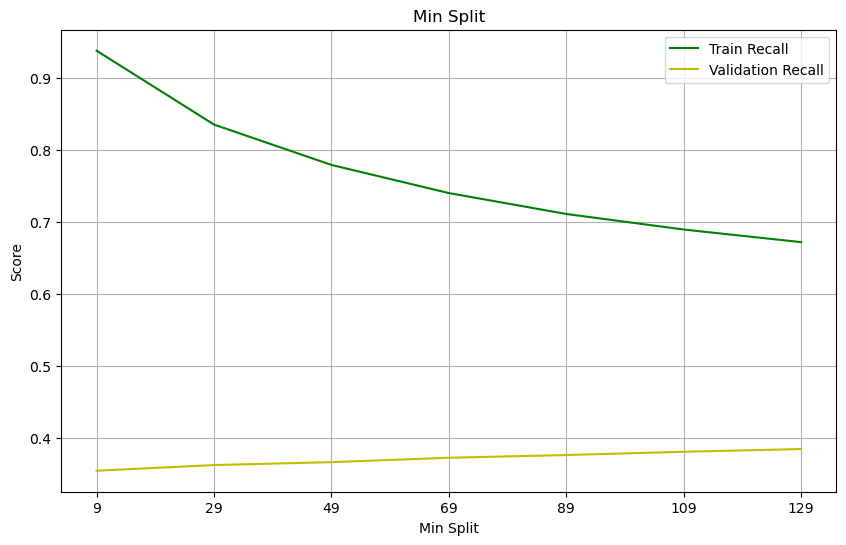

In [26]:
# Creating empty lists
dt_train_recall_min_split_list = []
dt_val_recall_min_split_list = []

# For loop to run through different min_samples_split
for n in range(9, 130, 20):     
    #Fit to the training data
    dt_model = DecisionTreeClassifier(min_samples_split=n)
    dt_model.fit(X_train_scaled, y_train)
    dt_y_train_pred = dt_model.predict(X_train_scaled)
    dt_y_val_pred = dt_model.predict(X_validation_scaled)

    # Score the model on the test set
    dt_train_recall = recall_score(y_train, dt_y_train_pred, average='macro')
    dt_val_recall = recall_score(y_validation, dt_y_val_pred, average='macro')
    
    # Appending scores to list
    dt_train_recall_min_split_list.append(dt_train_recall)
    dt_val_recall_min_split_list.append(dt_val_recall)
    
# Plot min_split
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(dt_train_recall_min_split_list))), y=dt_train_recall_min_split_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(dt_val_recall_min_split_list))), y=dt_val_recall_min_split_list, color='y', label='Validation Recall')
plt.xlabel('Min Split')
plt.ylabel('Score')
plt.title('Min Split')
plt.grid()
plt.xticks(ticks=np.arange(0,7,1), labels=np.arange(9, 130, 20))
plt.legend()
plt.show()

Insights from min_split graph:
1. The train scores start of really high but we can defintely see overfitting. 
2. We will pick a min split of 90 since it has the lowest difference between train and validation.

### Final Decision Trees Model

In [27]:
#Fit to the training data
final_dt_model = DecisionTreeClassifier(max_depth=9, min_samples_leaf=129, min_samples_split=129)
final_dt_model.fit(X_train_scaled, y_train)
final_dt_y_train_pred = final_dt_model.predict(X_train_scaled)
final_dt_y_val_pred = final_dt_model.predict(X_validation_scaled)

# Score the model on the test set
final_dt_train_recall = recall_score(y_train, final_dt_y_train_pred, average='macro')
final_dt_val_recall = recall_score(y_validation, final_dt_y_val_pred, average='macro')

# Print scores
print(f"Our final Decision Tree has a train recall score of {final_dt_train_recall}")
print(f"Our final Decision Tree has a validation recall score of {final_dt_val_recall}")

Our final Decision Tree has a train recall score of 0.4384588849830809
Our final Decision Tree has a validation recall score of 0.41107664574126473


Insights from final Decision Tree model:
1. We have less overfitting compared to our inital DT model.
2. We managed to bring it down to a ~ 2% difference.

In [123]:
# Adding scores to compiled scores df
inital_dt_model = {'Model': 'Decision Trees', 
                   'Hyperparamater': 'max_depth=9, min_samples_leaf=129, min_samples_split=129', 
                   'Train_Recall': final_dt_train_recall, 
                   'Validation_Recall': final_dt_val_recall, 
                   'Notes': 'Final DT. ~ 2% difference between train and validation'}

compiled_scores_df = compiled_scores_df.append(inital_dt_model, ignore_index=True)
compiled_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\449932102.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compiled_scores_df = compiled_scores_df.append(inital_dt_model, ignore_index=True)


,Model,Hyperparamater,Train_Recall,Validation_Recall,Notes
0,Logistic,None,0.379772,0.378139,Inital model. No overfitting
1,KNN,None,0.883944,0.393325,Initial model. Massive overfitting.
2,KNN,n_neighbors=421,0.481060,0.425187,Final KNN. Still has slight overfitting
3,Decision Trees,None,0.672272,0.384898,Inital model. Massive overfitting.
4,Decision Trees,"max_depth=9, min_samples_leaf=129, min_samples...",0.438459,0.411077,Final DT. ~ 2% difference between train and va...


## Clustering <a id="5.3"></a>

For our clustering model, we will choose 6 clusters right away since we have 6 severity classes. 

In [29]:
# Initialize, fit, predict, and score
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_train_scaled)

# Score
train_clustering_scores = silhouette_score(X_train_scaled, y_train)
validation_clustering_scores = silhouette_score(X_validation_scaled, y_validation)

# Printing scores
print(train_clustering_scores)
print(validation_clustering_scores)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-0.056522068926429476
0.0022035752660061803


### Insights from Clustering Model

1. We have extremly low scores for both train and validation.
2. With extremly low scores, we will no longer look into other clustering or hyperparamters in clustering.
3. The fire data has pretty big outliers and a lot of noise. Most of the hectares burned are under 1 hectare. On the other hand, we have fire occurances that have affected upto 1 million hectares. The clustering model might have looked at the data with a different set of clusters than we inputed.
4. There is a possiblilty that we could also have used the wrong clustering method. Since our inital score is too low, we will move on to other models rather than tweaking our clustering model.

In [124]:
# Appending into scores dataframe
clustering_model = {'Model': 'Clustering', 
                    'Hyperparamater': 'n_cluster=6', 
                    'Train_Recall': train_clustering_scores, 
                    'Validation_Recall': validation_clustering_scores, 
                    'Notes': 'Extremly low results. We will not use this model.'}
compiled_scores_df = compiled_scores_df.append(clustering_model, ignore_index=True)
compiled_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\3410965950.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compiled_scores_df = compiled_scores_df.append(clustering_model, ignore_index=True)


,Model,Hyperparamater,Train_Recall,Validation_Recall,Notes
0,Logistic,None,0.379772,0.378139,Inital model. No overfitting
1,KNN,None,0.883944,0.393325,Initial model. Massive overfitting.
2,KNN,n_neighbors=421,0.481060,0.425187,Final KNN. Still has slight overfitting
3,Decision Trees,None,0.672272,0.384898,Inital model. Massive overfitting.
4,Decision Trees,"max_depth=9, min_samples_leaf=129, min_samples...",0.438459,0.411077,Final DT. ~ 2% difference between train and va...
5,Clustering,n_cluster=6,-0.056522,0.002204,Extremly low results. We will not use this model.


## Random Forest <a id="5.4"></a>

We've seen a lot of overfitting when it came to individual decision trees. We will now try to employ random forest to see if we can get the model to predict better than a single decision tree. We will also look at hypertuning the random forest model with different max depths, min samples split, min samples leaf, and max features. We will leave bootstrapping to its default value of `True` so we can introduce random sampling of the data as well. 

### Inital random forest model

In [31]:
# Fit to training data
initial_random_forest_model = RandomForestClassifier() 
initial_random_forest_model.fit(X_train_scaled, y_train)
initial_rf_y_train_pred = initial_random_forest_model.predict(X_train_scaled)
initial_rf_y_val_pred = initial_random_forest_model.predict(X_validation_scaled)

# Score the model on the test set
initial_rf_train_recall = recall_score(y_train, initial_rf_y_train_pred, average='macro')
initial_rf_val_recall = recall_score(y_validation, initial_rf_y_val_pred, average='macro')

# Print scores
print(f"Our initial Random Forest model has a train recall score of {initial_rf_train_recall}")
print(f"Our initial Random Forest model has a validation recall score of {initial_rf_val_recall}")

Our initial Random Forest model has a train recall score of 0.9996044000569446
Our initial Random Forest model has a validation recall score of 0.41144887537795505


Insights from inital random forest model:
1. We have overfitting in our initial model. There is a ~ 37% difference between train and validation. 
2. The validation scores on the random forest model is slighly better than the validation score in the initial decision tree model.
3. We will need to tune our hyperparamters to see if we can get a better model that either has a higher validation score or a smaller gap between train/validation.

In [125]:
# Adding scores to compiled scores df
inital_rf_model = {'Model': 'Random Forest', 
                   'Hyperparamater': 'None', 
                    'Train_Recall': initial_rf_train_recall, 
                   'Validation_Recall': initial_rf_val_recall, 
                    'Notes': 'Initial model. Heavy overfitting.'}

compiled_scores_df = compiled_scores_df.append(inital_rf_model, ignore_index=True)
compiled_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\1063532307.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compiled_scores_df = compiled_scores_df.append(inital_rf_model, ignore_index=True)


,Model,Hyperparamater,Train_Recall,Validation_Recall,Notes
0,Logistic,None,0.379772,0.378139,Inital model. No overfitting
1,KNN,None,0.883944,0.393325,Initial model. Massive overfitting.
2,KNN,n_neighbors=421,0.481060,0.425187,Final KNN. Still has slight overfitting
3,Decision Trees,None,0.672272,0.384898,Inital model. Massive overfitting.
4,Decision Trees,"max_depth=9, min_samples_leaf=129, min_samples...",0.438459,0.411077,Final DT. ~ 2% difference between train and va...
5,Clustering,n_cluster=6,-0.056522,0.002204,Extremly low results. We will not use this model.
6,Random Forest,None,0.999604,0.411449,Initial model. Heavy overfitting.


### N Estimators Hyperparameter

We will look at tuning the n_estimators hyperparameter.

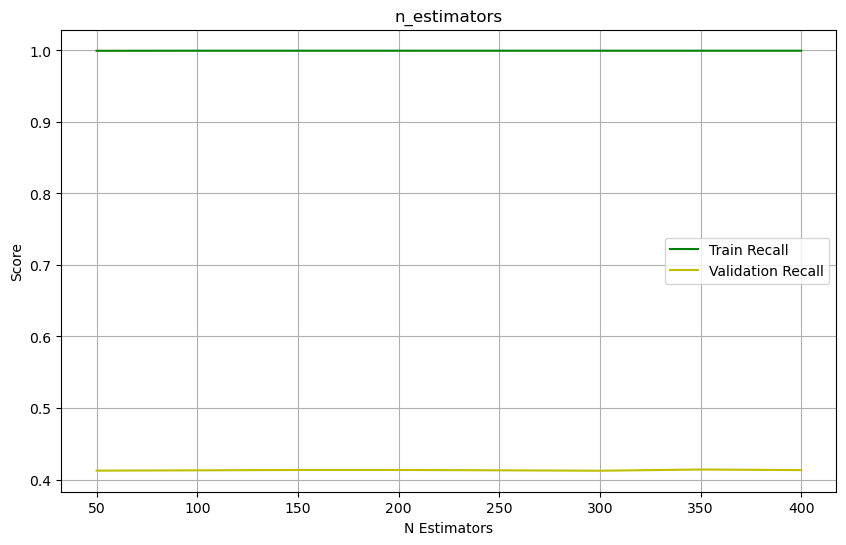

In [34]:
# Creating empty lists
nestimators_rf_train_recall_list = []
nestimators_rf_val_recall_list = []

# Running a for loop to look at different max_depth values
for n in range(50, 401, 50):     
    # Fit to training data
    random_forest_model = RandomForestClassifier(n_estimators=n) 
    random_forest_model.fit(X_train_scaled, y_train)
    rf_y_train_pred = random_forest_model.predict(X_train_scaled)
    rf_y_val_pred = random_forest_model.predict(X_validation_scaled)

    # Score the model
    nestimators_rf_train_recall = recall_score(y_train, rf_y_train_pred, average='macro')
    nestimators_rf_val_recall = recall_score(y_validation, rf_y_val_pred, average='macro')

    # Append on list
    nestimators_rf_train_recall_list.append(nestimators_rf_train_recall)
    nestimators_rf_val_recall_list.append(nestimators_rf_val_recall)

# Plot n_estimators
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(nestimators_rf_train_recall_list))), y=nestimators_rf_train_recall_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(nestimators_rf_val_recall_list))), y=nestimators_rf_val_recall_list, color='y', label='Validation Recall')
plt.xlabel('N Estimators')
plt.ylabel('Score')
plt.title('n_estimators')
plt.grid()
plt.xticks(ticks=np.arange(0,8,1), labels=np.arange(50, 401, 50))
plt.legend()
plt.show()

Insights from n_estimators graph:
1. There is no difference in scores when increasing n_estimators.
2. Since the increase in n_estimators only increases run time, we might stick with the default number depending on learning rate.

### Max Depth Hyperparameter

We will look at tuning the max depth hyperparameter.

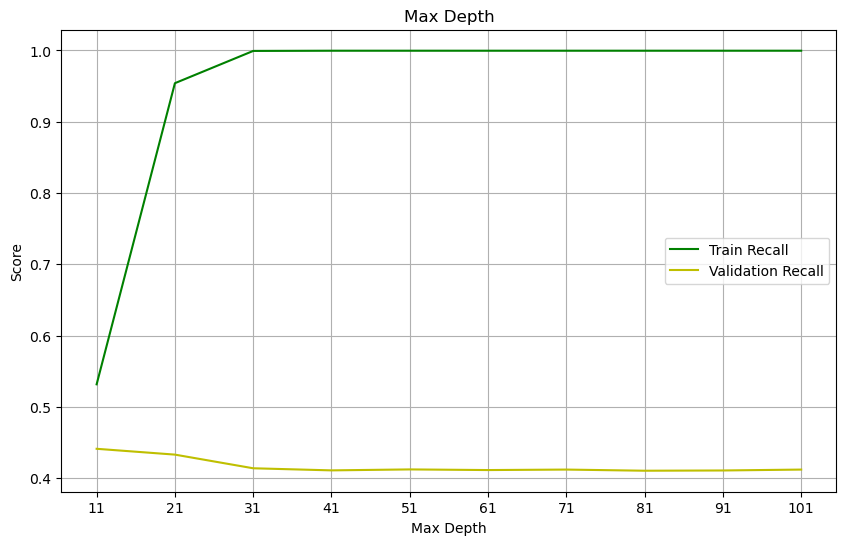

In [35]:
# Creating empty lists
max_depth_rf_train_recall_list = []
max_depth_rf_val_recall_list = []

# Running a for loop to look at different max_depth values
for n in range(11, 102, 10):     
    # Fit to training data
    random_forest_model = RandomForestClassifier(max_depth=n) 
    random_forest_model.fit(X_train_scaled, y_train)
    rf_y_train_pred = random_forest_model.predict(X_train_scaled)
    rf_y_val_pred = random_forest_model.predict(X_validation_scaled)

    # Score the model
    max_depth_rf_train_recall = recall_score(y_train, rf_y_train_pred, average='macro')
    max_depth_rf_val_recall = recall_score(y_validation, rf_y_val_pred, average='macro')

    # Append on list
    max_depth_rf_train_recall_list.append(max_depth_rf_train_recall)
    max_depth_rf_val_recall_list.append(max_depth_rf_val_recall)
    
# Plot max_depth
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(max_depth_rf_train_recall_list))), y=max_depth_rf_train_recall_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(max_depth_rf_val_recall_list))), y=max_depth_rf_val_recall_list, color='y', label='Validation Recall')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Max Depth')
plt.grid()
plt.xticks(ticks=np.arange(0,10,1), labels=np.arange(11, 102, 10))
plt.legend()
plt.show()

Insights from Max Depth graph:
1. Our train score starts fairly close to the validation and shoots up quickly. It levels out at around a 41 max depth and stays extremly overfitted from there onwards.
2. Our validation score does not move much and stays around the low 60s mark.
3. We will use a max depth of 11 as it avoids overfitting. 

### Min Samples Split Hyperparameter

We will look at tuning the min sample split hyperparameter.

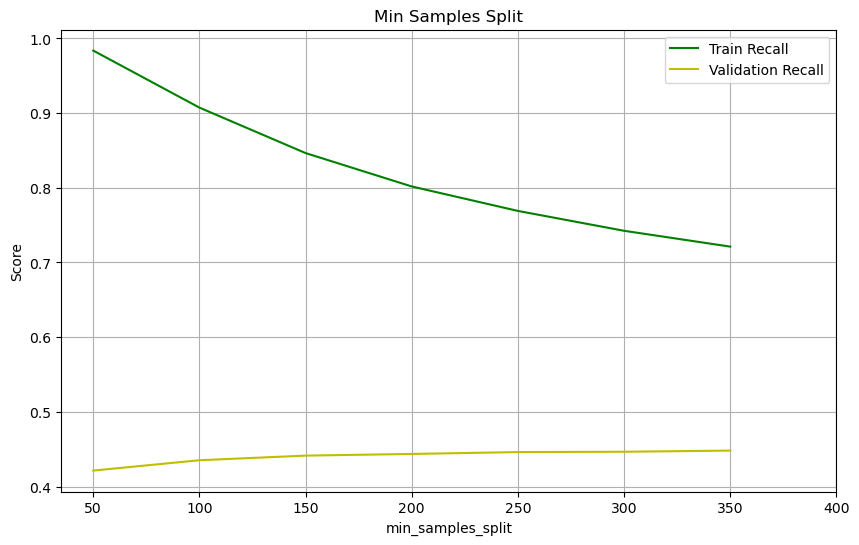

In [36]:
# Creating empty lists
min_split_rf_train_recall_list = []
min_split_rf_val_recall_list = []

# Running a for loop to look at different max_depth values
for n in range(10, 150, 20):     
    # Fit to training data
    random_forest_model = RandomForestClassifier(min_samples_split=n) 
    random_forest_model.fit(X_train_scaled, y_train)
    rf_y_train_pred = random_forest_model.predict(X_train_scaled)
    rf_y_val_pred = random_forest_model.predict(X_validation_scaled)

    # Score the model
    min_split_rf_train_recall = recall_score(y_train, rf_y_train_pred, average='macro')
    min_split_rf_val_recall = recall_score(y_validation, rf_y_val_pred, average='macro')

    # Append on list
    min_split_rf_train_recall_list.append(min_split_rf_train_recall)
    min_split_rf_val_recall_list.append(min_split_rf_val_recall)
    
# Plot min_split
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(min_split_rf_train_recall_list))), y=min_split_rf_train_recall_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(min_split_rf_val_recall_list))), y=min_split_rf_val_recall_list, color='y', label='Validation Recall')
plt.xlabel('min_samples_split')
plt.ylabel('Score')
plt.title('Min Samples Split')
plt.grid()
plt.xticks(ticks=np.arange(0,8,1), labels=np.arange(50, 401, 50))
plt.legend()
plt.show()

Insights from Min Samples Split graph:
1. We see massiver overfitting again with a low number of min samples split.
2. The validation score does not improve much over different values.
3. We will pick a min sample split of 400 to avoid overfitting.

### Min Samples Leaf Hyperparameter

We will look at tuning the min sample split hyperparameter.

In [37]:
# Creating empty lists
min_leaf_rf_train_recall_list = []
min_leaf_rf_val_recall_list = []

# Running a for loop to look at different max_depth values
for n in range(10, 151, 20):     
    # Fit to training data
    random_forest_model = RandomForestClassifier(min_samples_leaf=n) 
    random_forest_model.fit(X_train_scaled, y_train)
    rf_y_train_pred = random_forest_model.predict(X_train_scaled)
    rf_y_val_pred = random_forest_model.predict(X_validation_scaled)

    # Score the model
    min_leaf_rf_train_recall = recall_score(y_train, rf_y_train_pred, average='macro')
    min_leaf_rf_val_recall = recall_score(y_validation, rf_y_val_pred, average='macro')

    # Append on list
    min_leaf_rf_train_recall_list.append(min_leaf_rf_train_recall)
    min_leaf_rf_val_recall_list.append(min_leaf_rf_val_recall)

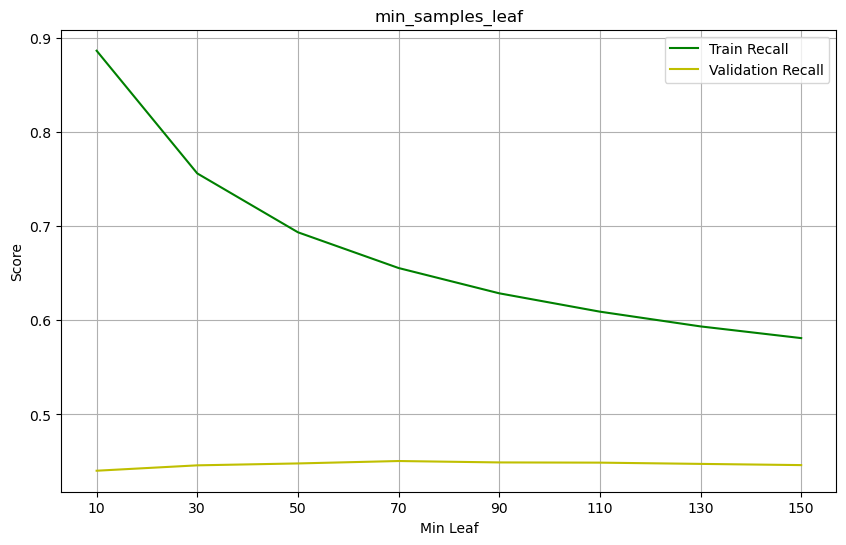

In [38]:
# Plot min_leaf
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(min_leaf_rf_train_recall_list))), y=min_leaf_rf_train_recall_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(min_leaf_rf_val_recall_list))), y=min_leaf_rf_val_recall_list, color='y', label='Validation Recall')
plt.xlabel('Min Leaf')
plt.ylabel('Score')
plt.title('min_samples_leaf')
plt.grid()
plt.xticks(ticks=np.arange(0,8,1), labels=np.arange(10, 151, 20))
plt.legend()
plt.show()

Insights from min_samples_leaf graph:
1. We see overfitting early on with roughly a 10% difference between train and validation.
2. The train recall score drops quickly before sloping down at around 70. We will use a 15 min leaf for our model since there is only a ~ 10% difference between train and validation.

### Max Features Hyperparameter

We will look at tuning the max features hyperparameter.

In [39]:
# Creating empty lists
max_feat_rf_train_recall_list = []
max_feat_rf_val_recall_list = []
# Running a for loop to look at different max_depth values
for n in range(10, 46, 5):     
    # Fit to training data
    random_forest_model = RandomForestClassifier(max_features=n) 
    random_forest_model.fit(X_train_scaled, y_train)
    rf_y_train_pred = random_forest_model.predict(X_train_scaled)
    rf_y_val_pred = random_forest_model.predict(X_validation_scaled)

    # Score the model
    max_feat_rf_train_recall = recall_score(y_train, rf_y_train_pred, average='macro')
    max_feat_rf_val_recall = recall_score(y_validation, rf_y_val_pred, average='macro')

    # Append on list
    max_feat_rf_train_recall_list.append(max_feat_rf_train_recall)
    max_feat_rf_val_recall_list.append(max_feat_rf_val_recall)

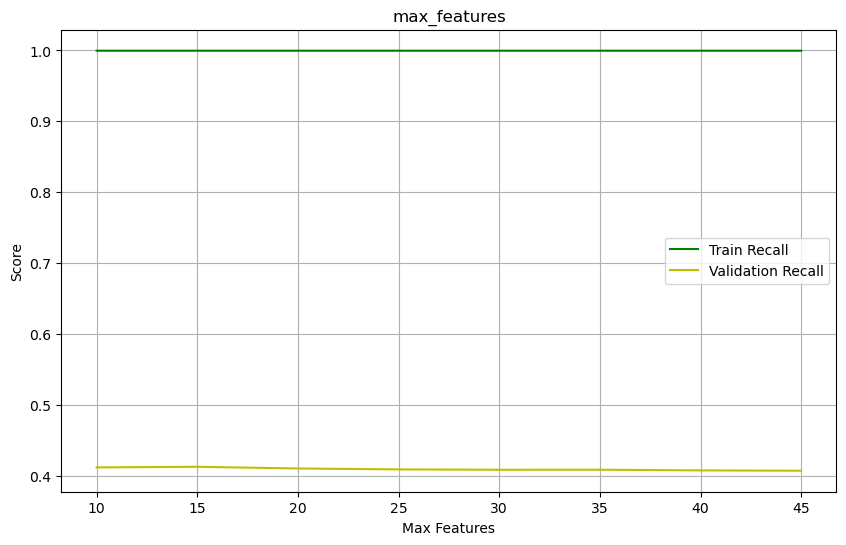

In [40]:
# Plot max_features
plt.figure(figsize=(10, 6))  
sns.lineplot(x=list(range(len(max_feat_rf_train_recall_list))), y=max_feat_rf_train_recall_list, color='g', label='Train Recall')
sns.lineplot(x=list(range(len(max_feat_rf_val_recall_list))), y=max_feat_rf_val_recall_list, color='y', label='Validation Recall')
plt.xlabel('Max Features')
plt.ylabel('Score')
plt.title('max_features')
plt.grid()
plt.xticks(ticks=np.arange(0,8,1), labels=np.arange(10, 46, 5))
plt.legend()
plt.show()

Insights from Max Features graph:
1. We do not see any improvement on train and validation scores throughout different max features.
2. There is massive overfitting no matter how many max features selected. 
3. We will keep the default value of this hyperparameter in our final model.

### Final Random Forest Model

In [41]:
# Fit to training data
final_random_forest_model = RandomForestClassifier(min_samples_leaf=150, 
                                                   max_depth=11, 
                                                   min_samples_split=400) 
final_random_forest_model.fit(X_train_scaled, y_train)
final_rf_y_train_pred = final_random_forest_model.predict(X_train_scaled)
final_rf_y_val_pred = final_random_forest_model.predict(X_validation_scaled)

# Score the model on the test set
final_rf_train_recall = recall_score(y_train, final_rf_y_train_pred, average='macro')
final_rf_val_recall = recall_score(y_validation, final_rf_y_val_pred, average='macro')

# Print scores
print(f"Our final Random Forest model has a train recall score of {final_rf_train_recall}")
print(f"Our final Random Forest model has a validation recall score of {final_rf_val_recall}")

Our final Random Forest model has a train recall score of 0.4954718179528455
Our final Random Forest model has a validation recall score of 0.44143377316907406


Insights from final Random Forest Model:

In [126]:
# Adding scores to compiled scores df
final_rf_model = {'Model': 'Random Forest', 
                   'Hyperparamater': 'min_samples_leaf=70, max_depth=11, min_samples_split=35', 
                    'Train_Recall': final_rf_train_recall, 
                   'Validation_Recall': final_rf_val_recall, 
                    'Notes': 'Final RF. Reduced overfitting but did not improve scores that much'}

compiled_scores_df = compiled_scores_df.append(final_rf_model, ignore_index=True)
compiled_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\1493603982.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compiled_scores_df = compiled_scores_df.append(final_rf_model, ignore_index=True)


,Model,Hyperparamater,Train_Recall,Validation_Recall,Notes
0,Logistic,None,0.379772,0.378139,Inital model. No overfitting
1,KNN,None,0.883944,0.393325,Initial model. Massive overfitting.
2,KNN,n_neighbors=421,0.481060,0.425187,Final KNN. Still has slight overfitting
3,Decision Trees,None,0.672272,0.384898,Inital model. Massive overfitting.
4,Decision Trees,"max_depth=9, min_samples_leaf=129, min_samples...",0.438459,0.411077,Final DT. ~ 2% difference between train and va...
5,Clustering,n_cluster=6,-0.056522,0.002204,Extremly low results. We will not use this model.
6,Random Forest,None,0.999604,0.411449,Initial model. Heavy overfitting.
7,Random Forest,"min_samples_leaf=70, max_depth=11, min_samples...",0.495472,0.441434,Final RF. Reduced overfitting but did not impr...


## Neural Network <a id="5.6"></a>

We experiment with different neural network hyperparamters to get the best possible model. We will use the following paramters for all models.

1. Output layer activation is softmax because we are dealing with a multiclass problem.
2. Loss function is SparseCategoricalCrossentropy since our target variable are integers ranging from 0 to 5.

In [43]:
# Creating dataframe to add model scores
nn_scores_df = pd.DataFrame(columns=['version', 'hidden_layer', 'nodes_per_layer', 'hidden_layer_activation', 'optimizer', 'epoch', 'train_accuracy', 'val_accuracy', 'notes'])

### Hidden layer activation function

##### Version 1

In [44]:
# Create a new sequential model
model1 = keras.Sequential()

# Declare the hidden layers
model1.add(layers.Dense(40, activation="tanh"))
model1.add(layers.Dense(40, activation="tanh"))
model1.add(layers.Dense(40, activation="tanh"))
model1.add(layers.Dense(40, activation="tanh"))
model1.add(layers.Dense(40, activation="tanh"))
model1.add(layers.Dense(40, activation="tanh"))
model1.add(layers.Dense(40, activation="tanh"))
model1.add(layers.Dense(40, activation="tanh"))

# Declare the output layer
model1.add(layers.Dense(6, activation="softmax"))

# Compile the model
model1.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history1 = model1.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [45]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history1.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history1.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn1_train_acc_list = history1.history['sparse_categorical_accuracy']
nn1_val_acc_list = history1.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.5034
Test Accuracy: 0.4573


In [46]:
# Adding scores to nueral network scores df
nn_model1 = {'version': '1', 
             'hidden_layer': '8', 
             'nodes_per_layer': '40', 
             'hidden_layer_activation': 'tanh', 
             'optimizer': 'adam',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model1, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\881245076.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model1, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none


#### Version 2

In [47]:
# Create a new sequential model
model2 = keras.Sequential()

# Declare the hidden layers
model2.add(layers.Dense(40, activation="gelu"))
model2.add(layers.Dense(40, activation="gelu"))
model2.add(layers.Dense(40, activation="gelu"))
model2.add(layers.Dense(40, activation="gelu"))
model2.add(layers.Dense(40, activation="gelu"))
model2.add(layers.Dense(40, activation="gelu"))
model2.add(layers.Dense(40, activation="gelu"))
model2.add(layers.Dense(40, activation="gelu"))

# Declare the output layer
model2.add(layers.Dense(6, activation="softmax"))

# Compile the model
model2.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history2 = model2.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [48]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history2.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history2.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn2_train_acc_list = history2.history['sparse_categorical_accuracy']
nn2_val_acc_list = history2.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.522
Test Accuracy: 0.4733


In [49]:
# Adding scores to nueral network scores df
nn_model2 = {'version': '2', 
             'hidden_layer': '8', 
             'nodes_per_layer': '40', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'adam',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model2, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\3868171460.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model2, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none


#### Version 3

In [50]:
# Create a new sequential model
model3 = keras.Sequential()

# Declare the hidden layers
model3.add(layers.Dense(40, activation="sigmoid"))
model3.add(layers.Dense(40, activation="sigmoid"))
model3.add(layers.Dense(40, activation="sigmoid"))
model3.add(layers.Dense(40, activation="sigmoid"))
model3.add(layers.Dense(40, activation="sigmoid"))
model3.add(layers.Dense(40, activation="sigmoid"))
model3.add(layers.Dense(40, activation="sigmoid"))
model3.add(layers.Dense(40, activation="sigmoid"))

# Declare the output layer
model3.add(layers.Dense(6, activation="softmax"))

# Compile the model
model3.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history3 = model3.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [51]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history3.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history3.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn3_train_acc_list = history3.history['sparse_categorical_accuracy']
nn3_val_acc_list = history3.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.4956
Test Accuracy: 0.4596


In [52]:
# Adding scores to nueral network scores df
nn_model3 = {'version': '3', 
             'hidden_layer': '8', 
             'nodes_per_layer': '40', 
             'hidden_layer_activation': 'sigmoid', 
             'optimizer': 'adam',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model3, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\300257627.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model3, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none


#### Version 4

In [53]:
# Create a new sequential model
model4 = keras.Sequential()

# Declare the hidden layers
model4.add(layers.Dense(40, activation="PReLU"))
model4.add(layers.Dense(40, activation="PReLU"))
model4.add(layers.Dense(40, activation="PReLU"))
model4.add(layers.Dense(40, activation="PReLU"))
model4.add(layers.Dense(40, activation="PReLU"))
model4.add(layers.Dense(40, activation="PReLU"))
model4.add(layers.Dense(40, activation="PReLU"))
model4.add(layers.Dense(40, activation="PReLU"))

# Declare the output layer
model4.add(layers.Dense(6, activation="softmax"))

# Compile the model
model4.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history4 = model4.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [54]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history4.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history4.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn4_train_acc_list = history4.history['sparse_categorical_accuracy']
nn4_val_acc_list = history4.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.5113
Test Accuracy: 0.4646


In [55]:
# Adding scores to nueral network scores df
nn_model4 = {'version': '4', 
             'hidden_layer': '8', 
             'nodes_per_layer': '40', 
             'hidden_layer_activation': 'PReLU', 
             'optimizer': 'adam',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model4, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\1282964183.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model4, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none


#### Version 5

In [56]:
# Create a new sequential model
model5 = keras.Sequential()

# Declare the hidden layers
model5.add(layers.Dense(40, activation="selu"))
model5.add(layers.Dense(40, activation="selu"))
model5.add(layers.Dense(40, activation="selu"))
model5.add(layers.Dense(40, activation="selu"))
model5.add(layers.Dense(40, activation="selu"))
model5.add(layers.Dense(40, activation="selu"))
model5.add(layers.Dense(40, activation="selu"))
model5.add(layers.Dense(40, activation="selu"))

# Declare the output layer
model5.add(layers.Dense(6, activation="softmax"))

# Compile the model
model5.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history5 = model5.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [57]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history5.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history5.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn5_train_acc_list = history5.history['sparse_categorical_accuracy']
nn5_val_acc_list = history5.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.5078
Test Accuracy: 0.4765


In [58]:
# Adding scores to nueral network scores df
nn_model5 = {'version': '5', 
             'hidden_layer': '8', 
             'nodes_per_layer': '40', 
             'hidden_layer_activation': 'selu', 
             'optimizer': 'adam',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model5, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\2470645176.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model5, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none


#### Plotting Scores: Hidden Layer Activations

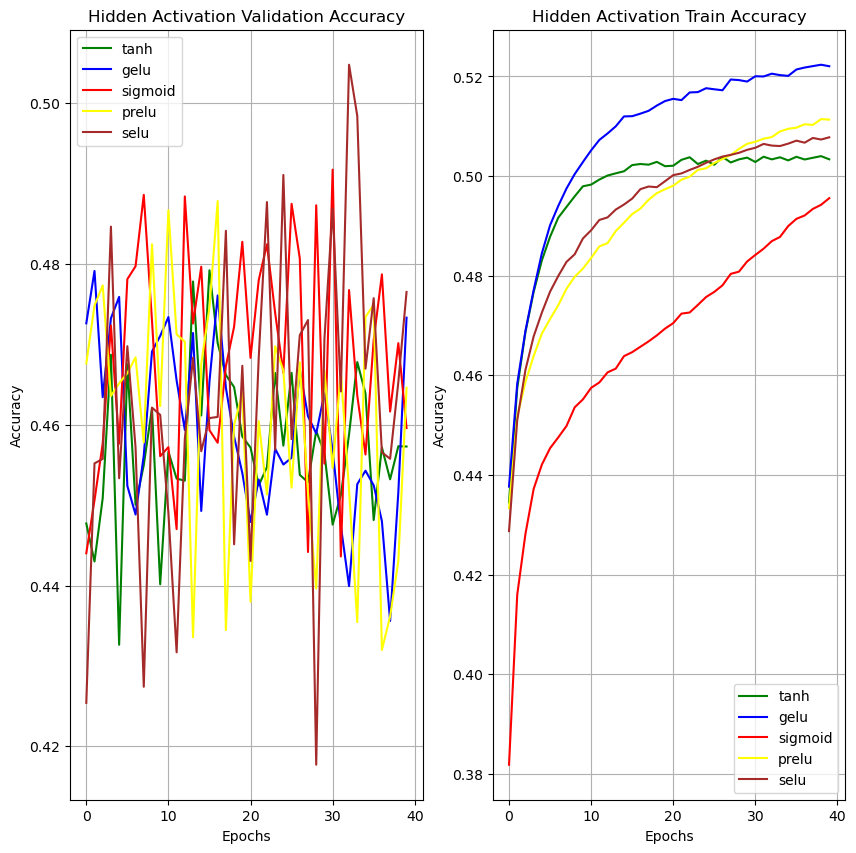

In [59]:
# Plotting different hidden activation layers
plt.subplots(1,2, figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(nn1_val_acc_list, color='green', label='tanh')
plt.plot(nn2_val_acc_list, color='blue', label='gelu')
plt.plot(nn3_val_acc_list, color='red', label='sigmoid')
plt.plot(nn4_val_acc_list, color='yellow', label='prelu')
plt.plot(nn5_val_acc_list, color='brown', label='selu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Hidden Activation Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(nn1_train_acc_list, color='green', label='tanh')
plt.plot(nn2_train_acc_list, color='blue', label='gelu')
plt.plot(nn3_train_acc_list, color='red', label='sigmoid')
plt.plot(nn4_train_acc_list, color='yellow', label='prelu')
plt.plot(nn5_train_acc_list, color='brown', label='selu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Hidden Activation Train Accuracy')
plt.legend()
plt.grid()

plt.show()

Insights from Hidden Activation graph:
1. The worst performing one is sigmoid for both train and validaition.
2. Tanh, prelu, and selu are scoring close to each other.
3. The gelu activation is definitly doing better in train sets and slightly better in validation sets. We will use this activation going forward in all our hidden layers.

### Optimizer

#### Version 6

In [60]:
# Create a new sequential model
model6 = keras.Sequential()

# Declare the hidden layers
model6.add(layers.Dense(40, activation="gelu"))
model6.add(layers.Dense(40, activation="gelu"))
model6.add(layers.Dense(40, activation="gelu"))
model6.add(layers.Dense(40, activation="gelu"))
model6.add(layers.Dense(40, activation="gelu"))
model6.add(layers.Dense(40, activation="gelu"))
model6.add(layers.Dense(40, activation="gelu"))
model6.add(layers.Dense(40, activation="gelu"))

# Declare the output layer
model6.add(layers.Dense(6, activation="softmax"))

# Compile the model
model6.compile(
    # Optimizer
    optimizer=keras.optimizers.Nadam(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history6 = model6.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [61]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history6.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history6.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn6_train_acc_list = history6.history['sparse_categorical_accuracy']
nn6_val_acc_list = history6.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.5238
Test Accuracy: 0.4638


In [62]:
# Adding scores to nueral network scores df
nn_model6 = {'version': '6', 
             'hidden_layer': '8', 
             'nodes_per_layer': '40', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'nadam',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model6, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\3104647888.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model6, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none


#### Version 7

In [63]:
# Create a new sequential model
model7 = keras.Sequential()

# Declare the hidden layers
model7.add(layers.Dense(40, activation="gelu"))
model7.add(layers.Dense(40, activation="gelu"))
model7.add(layers.Dense(40, activation="gelu"))
model7.add(layers.Dense(40, activation="gelu"))
model7.add(layers.Dense(40, activation="gelu"))
model7.add(layers.Dense(40, activation="gelu"))
model7.add(layers.Dense(40, activation="gelu"))
model7.add(layers.Dense(40, activation="gelu"))

# Declare the output layer
model7.add(layers.Dense(6, activation="softmax"))

# Compile the model
model7.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history7 = model7.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [64]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history7.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history7.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn7_train_acc_list = history7.history['sparse_categorical_accuracy']
nn7_val_acc_list = history7.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.5372
Test Accuracy: 0.4752


In [65]:
# Adding scores to nueral network scores df
nn_model7 = {'version': '7', 
             'hidden_layer': '8', 
             'nodes_per_layer': '40', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'adafactor',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model7, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\3723039588.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model7, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none


### Version 8

In [66]:
# Create a new sequential model
model8 = keras.Sequential()

# Declare the hidden layers
model8.add(layers.Dense(40, activation="gelu"))
model8.add(layers.Dense(40, activation="gelu"))
model8.add(layers.Dense(40, activation="gelu"))
model8.add(layers.Dense(40, activation="gelu"))
model8.add(layers.Dense(40, activation="gelu"))
model8.add(layers.Dense(40, activation="gelu"))
model8.add(layers.Dense(40, activation="gelu"))
model8.add(layers.Dense(40, activation="gelu"))

# Declare the output layer
model8.add(layers.Dense(6, activation="softmax"))

# Compile the model
model8.compile(
    # Optimizer
    optimizer=keras.optimizers.Ftrl(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history8 = model8.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [67]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history8.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history8.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn8_train_acc_list = history8.history['sparse_categorical_accuracy']
nn8_val_acc_list = history8.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.1654
Test Accuracy: 0.0262


In [68]:
# Adding scores to nueral network scores df
nn_model8 = {'version': '8', 
             'hidden_layer': '8', 
             'nodes_per_layer': '40', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'ftrl',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model8, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\2345607123.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model8, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none
7,8,8,40,gelu,ftrl,40,0.1654,0.0262,none


#### Plotting Optimizers Scores

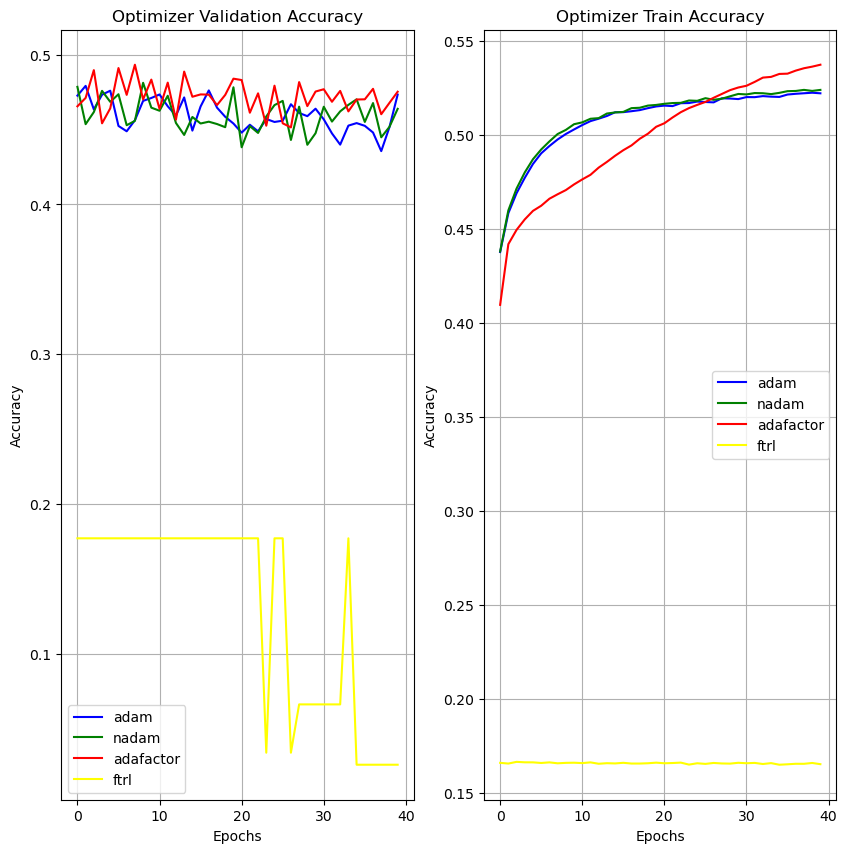

In [69]:
# Plotting different optimizers
plt.subplots(1,2, figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(nn2_val_acc_list, color='blue', label='adam')
plt.plot(nn6_val_acc_list, color='green', label='nadam')
plt.plot(nn7_val_acc_list, color='red', label='adafactor')
plt.plot(nn8_val_acc_list, color='yellow', label='ftrl')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Optimizer Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(nn2_train_acc_list, color='blue', label='adam')
plt.plot(nn6_train_acc_list, color='green', label='nadam')
plt.plot(nn7_train_acc_list, color='red', label='adafactor')
plt.plot(nn8_train_acc_list, color='yellow', label='ftrl')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Optimizer Train Accuracy')
plt.legend()
plt.grid()

plt.show()

### Nodes

#### Version 9

In [70]:
# Create a new sequential model
model9 = keras.Sequential()

# Declare the hidden layers
model9.add(layers.Dense(100, activation="gelu"))
model9.add(layers.Dense(100, activation="gelu"))
model9.add(layers.Dense(100, activation="gelu"))
model9.add(layers.Dense(100, activation="gelu"))
model9.add(layers.Dense(100, activation="gelu"))
model9.add(layers.Dense(100, activation="gelu"))
model9.add(layers.Dense(100, activation="gelu"))
model9.add(layers.Dense(100, activation="gelu"))

# Declare the output layer
model9.add(layers.Dense(6, activation="softmax"))

# Compile the model
model9.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history9 = model9.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [71]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history9.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history9.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn9_train_acc_list = history9.history['sparse_categorical_accuracy']
nn9_val_acc_list = history9.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.6797
Test Accuracy: 0.449


In [72]:
# Adding scores to nueral network scores df
nn_model9 = {'version': '9', 
             'hidden_layer': '8', 
             'nodes_per_layer': '100', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'adam',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model9, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\2172757041.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model9, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none
7,8,8,40,gelu,ftrl,40,0.1654,0.0262,none
8,9,8,100,gelu,adam,40,0.6797,0.4490,none


#### Version 10

In [73]:
# Create a new sequential model
model10 = keras.Sequential()

# Declare the hidden layers
model10.add(layers.Dense(160, activation="gelu"))
model10.add(layers.Dense(160, activation="gelu"))
model10.add(layers.Dense(160, activation="gelu"))
model10.add(layers.Dense(160, activation="gelu"))
model10.add(layers.Dense(160, activation="gelu"))
model10.add(layers.Dense(160, activation="gelu"))
model10.add(layers.Dense(160, activation="gelu"))
model10.add(layers.Dense(160, activation="gelu"))

# Declare the output layer
model10.add(layers.Dense(6, activation="softmax"))

# Compile the model
model10.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history10 = model10.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [74]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history10.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history10.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn10_train_acc_list = history10.history['sparse_categorical_accuracy']
nn10_val_acc_list = history10.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.7514
Test Accuracy: 0.4638


In [75]:
# Adding scores to nueral network scores df
nn_model10 = {'version': '10', 
             'hidden_layer': '8', 
             'nodes_per_layer': '160', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'adam',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model10, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\1883721666.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model10, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none
7,8,8,40,gelu,ftrl,40,0.1654,0.0262,none
8,9,8,100,gelu,adam,40,0.6797,0.4490,none
9,10,8,160,gelu,adam,40,0.7514,0.4638,none


#### Version 11

In [76]:
# Create a new sequential model
model11 = keras.Sequential()

# Declare the hidden layers
model11.add(layers.Dense(220, activation="gelu"))
model11.add(layers.Dense(220, activation="gelu"))
model11.add(layers.Dense(220, activation="gelu"))
model11.add(layers.Dense(220, activation="gelu"))
model11.add(layers.Dense(220, activation="gelu"))
model11.add(layers.Dense(220, activation="gelu"))
model11.add(layers.Dense(220, activation="gelu"))
model11.add(layers.Dense(220, activation="gelu"))

# Declare the output layer
model11.add(layers.Dense(6, activation="softmax"))

# Compile the model
model11.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history11 = model11.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [77]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history11.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history11.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn11_train_acc_list = history11.history['sparse_categorical_accuracy']
nn11_val_acc_list = history11.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.7946
Test Accuracy: 0.471


In [78]:
# Adding scores to nueral network scores df
nn_model11 = {'version': '11', 
             'hidden_layer': '8', 
             'nodes_per_layer': '220', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'adam',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model11, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\2656237832.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model11, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none
7,8,8,40,gelu,ftrl,40,0.1654,0.0262,none
8,9,8,100,gelu,adam,40,0.6797,0.4490,none
9,10,8,160,gelu,adam,40,0.7514,0.4638,none


#### Version 12

In [79]:
# Create a new sequential model
model12 = keras.Sequential()

# Declare the hidden layers
model12.add(layers.Dense(280, activation="gelu"))
model12.add(layers.Dense(280, activation="gelu"))
model12.add(layers.Dense(280, activation="gelu"))
model12.add(layers.Dense(280, activation="gelu"))
model12.add(layers.Dense(280, activation="gelu"))
model12.add(layers.Dense(280, activation="gelu"))
model12.add(layers.Dense(280, activation="gelu"))
model12.add(layers.Dense(280, activation="gelu"))

# Declare the output layer
model12.add(layers.Dense(6, activation="softmax"))

# Compile the model
model12.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history12 = model12.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

In [80]:
# Evaluate the model using the test data and generate predictions
train_accuracy = round(history12.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history12.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn12_train_acc_list = history12.history['sparse_categorical_accuracy']
nn12_val_acc_list = history12.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.8142
Test Accuracy: 0.4925


In [81]:
# Adding scores to nueral network scores df
nn_model12 = {'version': '12', 
             'hidden_layer': '8', 
             'nodes_per_layer': '280', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'adafactor',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model12, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\3044703579.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model12, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none
7,8,8,40,gelu,ftrl,40,0.1654,0.0262,none
8,9,8,100,gelu,adam,40,0.6797,0.4490,none
9,10,8,160,gelu,adam,40,0.7514,0.4638,none


### Plotting Nodes Scores

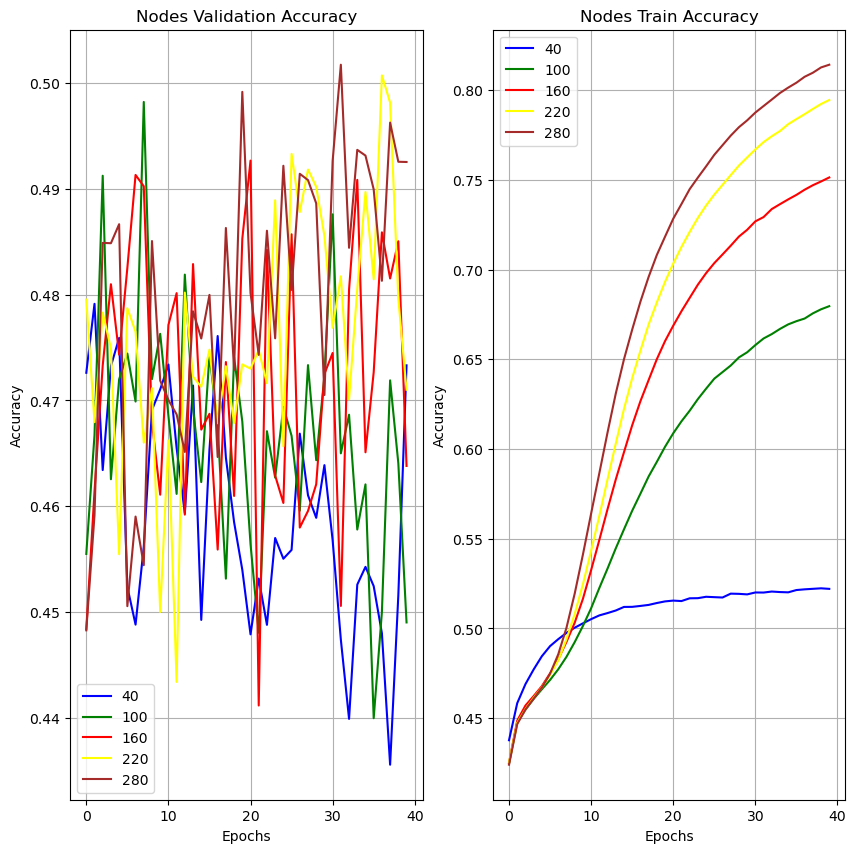

In [82]:
# Plotting different optimizers
plt.subplots(1,2, figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(nn2_val_acc_list, color='blue', label='40')
plt.plot(nn9_val_acc_list, color='green', label='100')
plt.plot(nn10_val_acc_list, color='red', label='160')
plt.plot(nn11_val_acc_list, color='yellow', label='220')
plt.plot(nn12_val_acc_list, color='brown', label='280')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Nodes Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(nn2_train_acc_list, color='blue', label='40')
plt.plot(nn9_train_acc_list, color='green', label='100')
plt.plot(nn10_train_acc_list, color='red', label='160')
plt.plot(nn11_train_acc_list, color='yellow', label='220')
plt.plot(nn12_train_acc_list, color='brown', label='280')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Nodes Train Accuracy')
plt.legend()
plt.grid()

plt.show()

Insights from Nodes Accuracy graph:
1. As expected, the least amount of nodes had the lowest train accuracy. There is a noticeable difference between 40 nodes and 100 nodes. 
2. The 100 nodes keeps up with training accuracy with the higher node models up untit about 30 epochs.
3. Having 160 and 280 nodes seem to be performing similiarly. Having 220 epochs seems give the best training score and the sweet spot.
5. The validation scores seem to flucate a lot. They are all on a similar path. 
6. There are a few peaks and valleys for every batch of nodes but 220 nodes also seems to have the best performing scores. We will pick this as our nodes going forward.

### Layers

#### Version 13

In [83]:
# Create a new sequential model
model13 = keras.Sequential()

# Declare the hidden layers
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))
model13.add(layers.Dense(220, activation="gelu"))

# Declare the output layer
model13.add(layers.Dense(6, activation="softmax"))

# Compile the model
model13.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history13 = model13.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

# Evaluate the model using the test data and generate predictions
train_accuracy = round(history13.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history13.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn13_train_acc_list = history13.history['sparse_categorical_accuracy']
nn13_val_acc_list = history13.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.166
Test Accuracy: 0.0664


In [84]:
# Adding scores to nueral network scores df
nn_model13 = {'version': '13', 
             'hidden_layer': '16', 
             'nodes_per_layer': '220', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'Adafactor',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model13, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\3175510695.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model13, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none
7,8,8,40,gelu,ftrl,40,0.1654,0.0262,none
8,9,8,100,gelu,adam,40,0.6797,0.4490,none
9,10,8,160,gelu,adam,40,0.7514,0.4638,none


#### Version 14

In [86]:
# Create a new sequential model
model14 = keras.Sequential()

# Declare the hidden layers
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))
model14.add(layers.Dense(220, activation="gelu"))

# Declare the output layer
model14.add(layers.Dense(6, activation="softmax"))

# Compile the model
model14.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history14 = model14.fit(X_train_scaled, y_train, epochs=40,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

# Evaluate the model using the test data and generate predictions
train_accuracy = round(history14.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history14.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn14_train_acc_list = history14.history['sparse_categorical_accuracy']
nn14_val_acc_list = history14.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.6734
Test Accuracy: 0.4481


In [87]:
# Adding scores to nueral network scores df
nn_model14 = {'version': '14', 
             'hidden_layer': '24', 
             'nodes_per_layer': '220', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'adafactor',
             'epoch': '40',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model14, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\1051287980.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model14, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none
7,8,8,40,gelu,ftrl,40,0.1654,0.0262,none
8,9,8,100,gelu,adam,40,0.6797,0.4490,none
9,10,8,160,gelu,adam,40,0.7514,0.4638,none


### Plotting Layer Scores

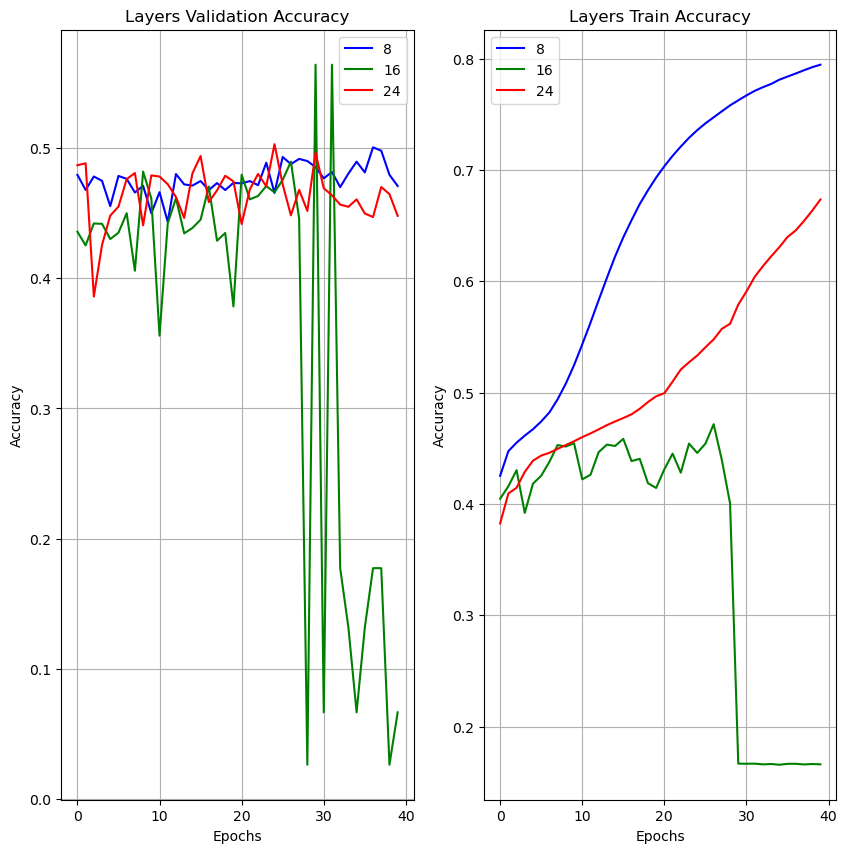

In [88]:
# Plotting different optimizers
plt.subplots(1,2, figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(nn11_val_acc_list, color='blue', label='8')
plt.plot(nn13_val_acc_list, color='green', label='16')
plt.plot(nn14_val_acc_list, color='red', label='24')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Layers Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(nn11_train_acc_list, color='blue', label='8')
plt.plot(nn13_train_acc_list, color='green', label='16')
plt.plot(nn14_train_acc_list, color='red', label='24')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Layers Train Accuracy')
plt.legend()
plt.grid()

plt.show()

Insights from Nodes graph:
1. Increasing the nodes does not improve performace of the model. 
2. Having 16 layers performs the worst both in training and validation.
3. We will keep 8 layers not only because it has the best accuracy but also because both the training and validation seem to have the potential to improve. They are still heading in somewhat an upward direction.

### Epochs

#### Version 15

In [90]:
# Create a new sequential model
model15 = keras.Sequential()

# Declare the hidden layers
model15.add(layers.Dense(220, activation="gelu"))
model15.add(layers.Dense(220, activation="gelu"))
model15.add(layers.Dense(220, activation="gelu"))
model15.add(layers.Dense(220, activation="gelu"))
model15.add(layers.Dense(220, activation="gelu"))
model15.add(layers.Dense(220, activation="gelu"))
model15.add(layers.Dense(220, activation="gelu"))
model15.add(layers.Dense(220, activation="gelu"))

# Declare the output layer
model15.add(layers.Dense(6, activation="softmax"))

# Compile the model
model15.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history15 = model15.fit(X_train_scaled, y_train, epochs=100,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

# Evaluate the model using the test data and generate predictions
train_accuracy = round(history15.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history15.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn15_train_acc_list = history15.history['sparse_categorical_accuracy']
nn15_val_acc_list = history15.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.8825
Test Accuracy: 0.4895


In [91]:
# Adding scores to nueral network scores df
nn_model15 = {'version': '15', 
             'hidden_layer': '8', 
             'nodes_per_layer': '100', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'adafactor',
             'epoch': '200',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': 'none'}

nn_scores_df = nn_scores_df.append(nn_model15, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\3856684624.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model15, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none
7,8,8,40,gelu,ftrl,40,0.1654,0.0262,none
8,9,8,100,gelu,adam,40,0.6797,0.4490,none
9,10,8,160,gelu,adam,40,0.7514,0.4638,none


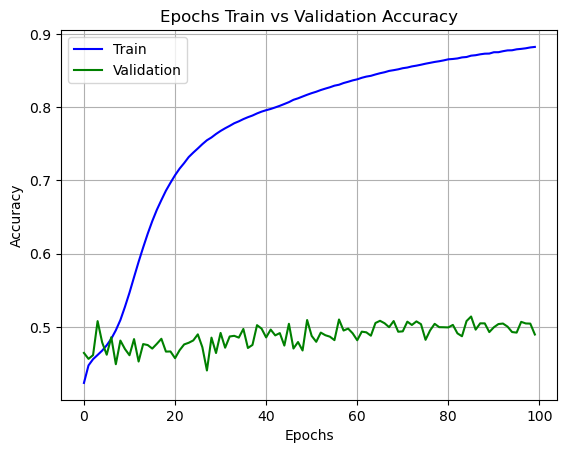

In [92]:
# Plotting epochs
plt.figure()
plt.plot(nn15_train_acc_list, color='blue', label='Train')
plt.plot(nn15_val_acc_list, color='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs Train vs Validation Accuracy')
plt.legend()
plt.grid()

Insights from Epoch Train vs Validation Accuracy graph:
1. The validation accuracy increases from the high 40s to the low 50s. 
2. The train accuracy significantly increases past 10 epochs.
3. We see severe overfitting past 10 epochs. 

#### Version 16

In [93]:
# Create a new sequential model
model16 = keras.Sequential()

# Declare the hidden layers
model16.add(layers.Dense(220, activation="gelu"))
model16.add(layers.Dropout(0.2))
model16.add(layers.Dense(220, activation="gelu"))
model16.add(layers.Dropout(0.2))
model16.add(layers.Dense(220, activation="gelu"))
model16.add(layers.Dropout(0.2))
model16.add(layers.Dense(220, activation="gelu"))
model16.add(layers.Dropout(0.2))
model16.add(layers.Dense(220, activation="gelu"))
model16.add(layers.Dropout(0.2))
model16.add(layers.Dense(220, activation="gelu"))
model16.add(layers.Dropout(0.2))
model16.add(layers.Dense(220, activation="gelu"))
model16.add(layers.Dropout(0.2))
model16.add(layers.Dense(220, activation="gelu"))
model16.add(layers.Dropout(0.2))

# Declare the output layer
model16.add(layers.Dense(6, activation="softmax"))

# Compile the model
model16.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history16 = model16.fit(X_train_scaled, y_train, epochs=80,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

# Evaluate the model using the test data and generate predictions
train_accuracy = round(history16.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history16.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn16_train_acc_list = history16.history['sparse_categorical_accuracy']
nn16_val_acc_list = history16.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.5294
Test Accuracy: 0.4775


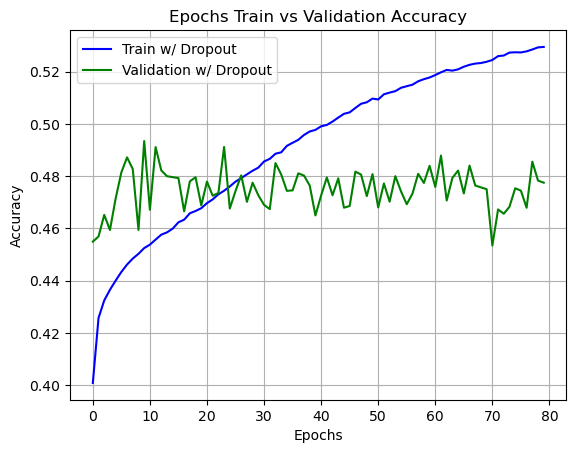

In [99]:
# Plotting epochs
plt.figure()
plt.plot(nn16_train_acc_list, color='blue', label='Train w/ Dropout')
plt.plot(nn16_val_acc_list, color='green', label='Validation w/ Dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs Train vs Validation Accuracy')
plt.legend()
plt.grid()

Insights from Train vs Validation w/ Dropout graph:
1. There is overfitting under 20 epochs. The train accuracy goes up significantly after that.
2. The validation continues to be the same from 0 to 80 epochs. 
3. Will be usefull to combine with batch normalization to reduce overfitting in the higher epochs. 

In [94]:
# Adding scores to nueral network scores df
nn_model16 = {'version': '16', 
             'hidden_layer': '8', 
             'nodes_per_layer': '220', 
             'hidden_layer_activation': 'gelu', 
             'optimizer': 'adafactor',
             'epoch': '80',
             'train_accuracy': train_accuracy, 
             'val_accuracy': validation_accuracy, 
             'notes': '.'}

nn_scores_df = nn_scores_df.append(nn_model16, ignore_index=True)
nn_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\1489548148.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_scores_df = nn_scores_df.append(nn_model16, ignore_index=True)


,version,hidden_layer,nodes_per_layer,hidden_layer_activation,optimizer,epoch,train_accuracy,val_accuracy,notes
0,1,8,40,tanh,adam,40,0.5034,0.4573,none
1,2,8,40,gelu,adam,40,0.5220,0.4733,none
2,3,8,40,sigmoid,adam,40,0.4956,0.4596,none
3,4,8,40,PReLU,adam,40,0.5113,0.4646,none
4,5,8,40,selu,adam,40,0.5078,0.4765,none
5,6,8,40,gelu,nadam,40,0.5238,0.4638,none
6,7,8,40,gelu,adafactor,40,0.5372,0.4752,none
7,8,8,40,gelu,ftrl,40,0.1654,0.0262,none
8,9,8,100,gelu,adam,40,0.6797,0.4490,none
9,10,8,160,gelu,adam,40,0.7514,0.4638,none


#### Version 17

In [95]:
# Create a new sequential model
model17 = keras.Sequential()

# Declare the hidden layers
model17.add(layers.Dense(220, activation="gelu"))
model17.add(layers.Dropout(0.2))
model17.add(layers.BatchNormalization()) 
model17.add(layers.Dense(220, activation="gelu"))
model17.add(layers.Dropout(0.2))
model17.add(layers.BatchNormalization()) 
model17.add(layers.Dense(220, activation="gelu"))
model17.add(layers.Dropout(0.2))
model17.add(layers.BatchNormalization()) 
model17.add(layers.Dense(220, activation="gelu"))
model17.add(layers.Dropout(0.2))
model17.add(layers.BatchNormalization()) 
model17.add(layers.Dense(220, activation="gelu"))
model17.add(layers.Dropout(0.2))
model17.add(layers.BatchNormalization()) 
model17.add(layers.Dense(220, activation="gelu"))
model17.add(layers.Dropout(0.2))
model17.add(layers.BatchNormalization()) 
model17.add(layers.Dense(220, activation="gelu"))
model17.add(layers.Dropout(0.2))
model17.add(layers.BatchNormalization()) 
model17.add(layers.Dense(220, activation="gelu"))
model17.add(layers.Dropout(0.2))

# Declare the output layer
model17.add(layers.Dense(6, activation="softmax"))

# Compile the model
model17.compile(
    # Optimizer
    optimizer=keras.optimizers.Adafactor(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model
history17 = model17.fit(X_train_scaled, y_train, epochs=80,
                      validation_data=(X_validation_scaled, y_validation),
                      verbose=0)

# Evaluate the model using the test data and generate predictions
train_accuracy = round(history17.history['sparse_categorical_accuracy'][-1], 4)
validation_accuracy = round(history17.history['val_sparse_categorical_accuracy'][-1], 4)

# Printing results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {validation_accuracy}")

# Saving values to be plotted later
nn17_train_acc_list = history17.history['sparse_categorical_accuracy']
nn17_val_acc_list = history17.history['val_sparse_categorical_accuracy']

Train Accuracy: 0.4923
Test Accuracy: 0.4736


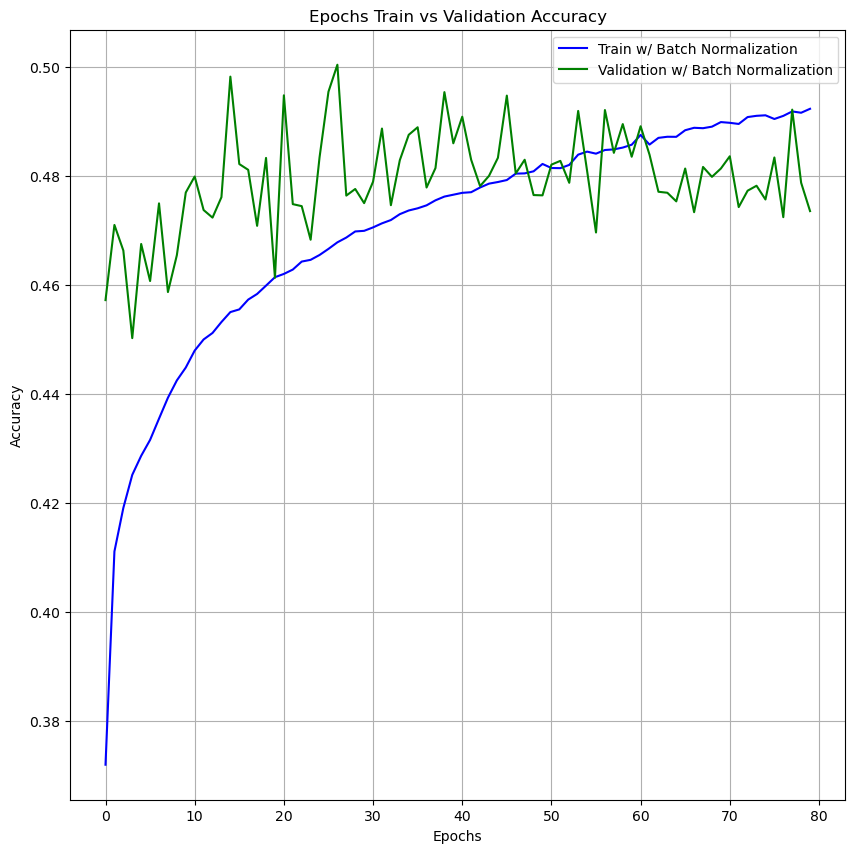

In [98]:
# Plotting epochs
plt.figure(figsize=(10,10))
plt.plot(nn17_train_acc_list, color='blue', label='Train w/ Batch Normalization')
plt.plot(nn17_val_acc_list, color='green', label='Validation w/ Batch Normalization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs Train vs Validation Accuracy')
plt.legend()
plt.grid()

Insights from Train vs Validation w/ Batch Normalization graph:
1. There is underfitting with less than 50 epochs. 
2. The model starts performing better past 60 epochs. 

In [127]:
# Appending into scores dataframe
nn_model = {'Model': 'Neural Network', 
                    'Hyperparamater': '8 layers, 220 nodes per layer, gelu hidden layer activation, adafactor optimizer, 80 epochs', 
                    'Train_Recall': train_accuracy, 
                    'Validation_Recall': validation_accuracy, 
                    'Notes': 'Extremly low results. No overfitting.'}
compiled_scores_df = compiled_scores_df.append(nn_model, ignore_index=True)
compiled_scores_df

C:\Users\nicod\AppData\Local\Temp\ipykernel_21012\4122498576.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compiled_scores_df = compiled_scores_df.append(nn_model, ignore_index=True)


,Model,Hyperparamater,Train_Recall,Validation_Recall,Notes
0,Logistic,None,0.379772,0.378139,Inital model. No overfitting
1,KNN,None,0.883944,0.393325,Initial model. Massive overfitting.
2,KNN,n_neighbors=421,0.481060,0.425187,Final KNN. Still has slight overfitting
3,Decision Trees,None,0.672272,0.384898,Inital model. Massive overfitting.
4,Decision Trees,"max_depth=9, min_samples_leaf=129, min_samples...",0.438459,0.411077,Final DT. ~ 2% difference between train and va...
5,Clustering,n_cluster=6,-0.056522,0.002204,Extremly low results. We will not use this model.
6,Random Forest,None,0.999604,0.411449,Initial model. Heavy overfitting.
7,Random Forest,"min_samples_leaf=70, max_depth=11, min_samples...",0.495472,0.441434,Final RF. Reduced overfitting but did not impr...
8,Neural Network,"8 layers, 220 nodes per layer, gelu hidden lay...",0.492300,0.473600,Extremly low results. No overfitting.


In [131]:
# Saving model for possible deployment
import pickle
pickle.dump(model17, open('./nnmodel.sav', 'wb'))

# Conclusion <a id="6"></a>

#### Reviewing Severity Buckets

To help us understand where the model is misclassifying the data, we will look at the severity buckets again.


| Number | Area (Hectares) |
|--------|-----------------|
| 0 | Upto 0.1 |
| 1 | 0.11 – 1.0 |
| 2 | 1.1 – 10 |
| 3 | 10.1 - 100 |
| 4 | 100.01 - 1000 |
| 5 | over 1000 |

## Best model: Neural Network

We will review our scores for our models.

In [102]:
# Printing scores
compiled_scores_df

,Model,Hyperparamater,Train_Recall,Validation_Recall,Notes
0,Logistic,None,0.379772,0.378139,Inital model. No overfitting
1,KNN,None,0.883944,0.393325,Initial model. Massive overfitting.
2,KNN,n_neighbors=421,0.481060,0.425187,Final KNN. Still has slight overfitting
3,Decision Trees,None,0.999607,0.353703,Inital model. Massive overfitting.
4,Decision Trees,"max_depth=15, min_samples_leaf=36, min_samples...",0.438459,0.411077,Final DT. ~ 2% difference between train and va...
5,Clustering,n_cluster=6,-0.056522,0.002204,Extremly low results. We will not use this model.
6,Random Forest,None,0.999604,0.411449,Initial model. Heavy overfitting.
7,Random Forest,"min_samples_leaf=70, max_depth=11, min_samples...",0.495472,0.441434,Final RF. Reduced overfitting but did not impr...
8,Neural Network,"8 layers, 220 nodes per layer, gelu hidden lay...",0.492300,0.473600,Extremly low results. We will not use this model.


Our best model is the neural network. It has the highest train recall score without overfitting. We will look into the model performance more closely.

### Predicting test results

In [108]:
# Run test data
result = model17.evaluate(X_test_scaled,y_test, verbose=0)

# Printing scores
print(f"Our Neural Network model has a test recall score of {result[1]}")

Our Neural Network model has a test recall score of 0.4747386872768402


#### Confusion Matrix for Test Data

2407/2407 [==============================] - 3s 1ms/step


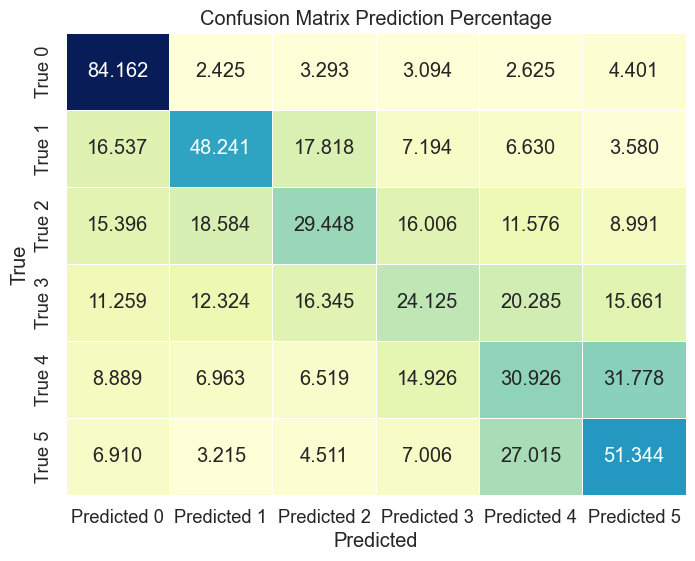

In [117]:
# Generate soft predictions
nn_y_test_pred = model17.predict(X_test_scaled)

# Convert to hard predictions
hard_predictions = tf.argmax(nn_y_test_pred, axis=1)

# Generate confusion matrix using hard predictions
cf_matrix = confusion_matrix(y_test, hard_predictions, normalize='true')

# create a dataframe for predictions
cftest_df = pd.DataFrame(cf_matrix*100, 
                         columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4', 'Predicted 5'], 
                         index=['True 0', 'True 1', 'True 2', 'True 3', 'True 4', 'True 5']
                        )

# Plotting values
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cftest_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=False, linewidths=0.5)
plt.title('Confusion Matrix Prediction Percentage')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Insights from Confsuion Matrix for Test Data:
* Severity 0: Our model was able to predict fires less than 0.1 hectares with an 84% accuracy.
* Severity 1: It was only able to predict severity 1 correctly 48% of the time. Most of the errors came from the model thinking it was a 0 or 2 in severity(16% and 17% respectively).
* Severity 2: It had a hard time predicting severity 2. It only got 29% of it correctly
* Severity 3: Only 24% of severity 3 occurances were predicted correctly. It again had a difficult time identifying severity 3 occurances. It thought that 20% of them were severity 4 and 16% were severity 2.
* Severtiy 4: It predicted the correct severity 4 occurance 30% of the time. It misclassfied another 31% as severity 5. 
* Severity 5: The model was able to learn severity 5 pretty well. It predicted the correct severity 51% of the time. It misclassfied 27% of severity 5 occurances as severity 4. 

## Next Steps  <a id="6.3"></a>

Although we have gained a lot of insights in our project, there is always room for improvement. Below are future steps for this project.
1. Incorporate more weather data such as humidity, cloud cover, and wind.
2. Research and incorporate data on forest debris.
3. Research on how to incorporate topography and how it impacts severity.
4. Try more methods to deal with class imbalance
5. Experiment on time series models.
6. Fine tune existing models by looking at false negatives for each model to understand where their weaknesses are. 
7. Research and possibly create a loss function specific to wildland fires.
8. Find new data for wildland fires post 2021 and test it against the model. Possibly rerun models on new data to predict the next seasons wildland fire occurances. 
9. Deploy a website that can be used by companies and government agencies to assess risk of specific locations.  

[Back to top](#top)